# Statistical modelling: Mixed effects model

**Author: Jakob Nyström, 5563**

In this notebook we train models that predict TOC concentration based on chemical properties, weather, discharge, physical attributes of the lakes, and catchment areas, in our data sets. We use a linear mixed effects model (LME) from the `statsmodels` library.

In [246]:
import os
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple
from scipy.stats import shapiro

In [247]:
import jupyter_black

jupyter_black.load(lab=False)

In [248]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# Suppress the FutureWarnings related to is_sparse
warnings.filterwarnings(
    "ignore", category=FutureWarning, module="sklearn.utils.validation"
)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", module="seaborn")
warnings.simplefilter(action="ignore", category=FutureWarning)
pd.set_option("display.max_rows", 100)

## 1. Load and join all data sets

The data that we want to use comes from four different data sets (lake chemistry, meteorology, hydrology and physical / catchment attributes), so the first step is to join all of these together. 

In [249]:
# Load lake chemistry panel data
df_lake = pd.read_csv("../data/lake_chem_data_clean.csv")
df_lake.head()

,MD-MVM Id,Survey station,Latitude,Longitude,County,Municipality,MS_CD C3,Sample date,Sample year,Sample month,...,Water temp (°C),Tot-N (µg/l N),Abs_F 420 (/m),SUVA_254 (m*l/mg),Organic N (µg/l N),Inorganic N (µg/l N),TOC:TON (mol/l),Organic P (µg/l P),Inorganic P (µg/l P),TOC:TOP (mol/l)
0,54,Spjutsjön,60.638793,15.445276,Dalarnas län,Falun,WA42559716,2001-03-28,2001,3,...,0.6,409.0,1.06,NaN,201.0,208.0,61.513265,7.0,1.0,7809.079772
1,54,Spjutsjön,60.638793,15.445276,Dalarnas län,Falun,WA42559716,2001-05-21,2001,5,...,10.2,360.0,1.02,NaN,256.0,104.0,37.362236,4.0,1.0,10571.725918
2,54,Spjutsjön,60.638793,15.445276,Dalarnas län,Falun,WA42559716,2001-08-22,2001,8,...,18.6,195.0,0.58,NaN,185.0,10.0,107.185530,4.0,1.0,21916.992757
3,54,Spjutsjön,60.638793,15.445276,Dalarnas län,Falun,WA42559716,2001-10-15,2001,10,...,10.3,383.0,0.70,NaN,353.0,30.0,28.417294,6.0,2.0,7391.613243
4,54,Spjutsjön,60.638793,15.445276,Dalarnas län,Falun,WA42559716,2002-02-26,2002,2,...,1.5,385.0,0.70,NaN,203.0,182.0,55.161258,7.0,1.0,7072.374133


In [250]:
# Load weather data
df_met = pd.read_csv("../data/weather_data_clean.csv")
df_met.head()

,MD-MVM Id,Survey station,Latitude,Longitude,Sample date,Temp station id,Temp station dist,Temp station name,Precip station id,Precip station dist,...,Precip 1w avg,Precip 1w acc,Precip 2w avg,Precip 2w acc,Precip 4w avg,Precip 4w acc,Precip 12w avg,Precip 12w acc,Precip 52w avg,Precip 52w acc
0,54,Spjutsjön,60.638793,15.445276,2001-03-28,105370,11.8,Falun-Lugnet,105470,11.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,54,Spjutsjön,60.638793,15.445276,2001-05-21,105370,11.8,Falun-Lugnet,105470,11.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,54,Spjutsjön,60.638793,15.445276,2001-08-22,105370,11.8,Falun-Lugnet,105470,11.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,54,Spjutsjön,60.638793,15.445276,2001-10-15,105370,11.8,Falun-Lugnet,105470,11.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,54,Spjutsjön,60.638793,15.445276,2002-02-26,105370,11.8,Falun-Lugnet,105470,11.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [251]:
# Load lake attribute data
df_geo_all = pd.read_csv("../data/merged_landscape_data.csv")

# Drop columns we don't need and rename for readability / consistency
df_geo = (
    df_geo_all.drop(
        [
            "Unnamed: 0",
            "aro_area",
            "source",
            "area_viv1",
            "dif_vtd12",
            "dist_vtd1",
            "x_utlopp",
            "y_utlopp",
            "elev_utl",
            "lokal_area",
            "total_area",
            "vivan1_chk",
            "delaro_chk",
            "slu_id_2",
            "FREQUENCY",
            "slu_id_n_1",
            "Shape_Length",
            "Shape_Area",
            "Nationellt övervakningsstations-ID",
            "SMHI-ID",
            "Stationskoordinat_N_X",
            "Stationskoordinat_E_Y",
            "Län",
            "Kommun",
            "MS_CD_C3",
            "Stationsnamn",
            "EU_id",
            "SWB_TYPES_LW",
            "Mean(MEDDJ)",
            "Mean(MAXDJ)",
            "Area_Code",
        ],
        axis="columns",
    )
    .rename(
        columns={
            "MD_MVM_Id": "MD-MVM Id",
            "Altitud": "Altitude",
            "Skog": "Forest",
            "Vatten": "Water",
            "Sankmark": "Wetland",
            "Hygge": "Clearing",
            "Öppen_mark": "Open land",
            "Jordbruksmark": "Agriculture",
            "Fjäll": "Mountains",
            "Tätort": "Urban area",
            "Lake_Area": "Surface area",
        }
    )
    .replace(np.nan, 0)
)
df_geo.head()

,MD-MVM Id,Altitude,Forest,Water,Wetland,Clearing,Open land,Agriculture,Mountains,Urban area,Surface area
0,100,204.723999,78.313054,14.901295,6.503163,0.282489,0.000000,0.000000,0.00000,0.0,0.404284
1,101,83.518600,76.656609,10.739424,7.119084,1.991119,2.956950,0.536814,0.00000,0.0,0.186749
2,102,240.341995,74.568727,2.870697,18.861402,3.699174,0.000000,0.000000,0.00000,0.0,0.419940
3,103,436.540008,71.579561,6.335409,17.872005,0.624615,0.382230,0.000000,3.20618,0.0,0.209618
4,104,543.198975,50.432686,22.363232,26.307028,0.394195,0.502858,0.000000,0.00000,0.0,0.745124


In [252]:
# Load water residence time (WRT)
df_wrt = pd.read_csv(
    "../data/Final_Merged_Dataset_With_WRT.csv")[
    [
        "MD-MVM Id", 
        "Date", 
        "Mean(MEDDJ)", 
        "30-day Avg Total Water Flow",
        "Mean Water Residence Time (WRT)",
    ]
].rename(columns={
    "Mean Water Residence Time (WRT)": "WRT", 
    "Date": "Sample date",
    "Mean(MEDDJ)": "Mean depth",
    "30-day Avg Total Water Flow": "Discharge 30d avg"
}
)

df_wrt.head()

/var/folders/pd/qpp_vpcn3wv209_68c5q1_r80000gn/T/ipykernel_68262/2832900838.py:2: DtypeWarning: Columns (77) have mixed types. Specify dtype option on import or set low_memory=False.
  df_wrt = pd.read_csv(


,MD-MVM Id,Sample date,Mean depth,Discharge 30d avg,WRT
0,54,2001-03-28,1.5,NaN,NaN
1,54,2001-05-21,1.5,NaN,NaN
2,54,2001-08-22,1.5,NaN,NaN
3,54,2001-10-15,1.5,NaN,NaN
4,54,2002-02-26,1.5,NaN,NaN


In [253]:
# Join data sets using MD-MVM Id as key

# Lake chemistry and meterological data
df_lake_met = df_lake.join(
    df_met.drop(["Survey station", "Latitude", "Longitude"], axis="columns").set_index(
        ["MD-MVM Id", "Sample date"]
    ),
    on=["MD-MVM Id", "Sample date"],
)

# Physical attributes and catchment
df_lake_met_catch = df_lake_met.join(df_geo.set_index("MD-MVM Id"), on="MD-MVM Id")

# Hydrological data
df_all = df_lake_met_catch.join(
    df_wrt.set_index(["MD-MVM Id", "Sample date"]), on=["MD-MVM Id", "Sample date"]
)

df_all.head()

,MD-MVM Id,Survey station,Latitude,Longitude,County,Municipality,MS_CD C3,Sample date,Sample year,Sample month,...,Wetland,Clearing,Open land,Agriculture,Mountains,Urban area,Surface area,Mean depth,Discharge 30d avg,WRT
0,54,Spjutsjön,60.638793,15.445276,Dalarnas län,Falun,WA42559716,2001-03-28,2001,3,...,3.676818,12.016456,0.0,0.0,0.0,0.0,0.405412,1.5,NaN,NaN
1,54,Spjutsjön,60.638793,15.445276,Dalarnas län,Falun,WA42559716,2001-05-21,2001,5,...,3.676818,12.016456,0.0,0.0,0.0,0.0,0.405412,1.5,NaN,NaN
2,54,Spjutsjön,60.638793,15.445276,Dalarnas län,Falun,WA42559716,2001-08-22,2001,8,...,3.676818,12.016456,0.0,0.0,0.0,0.0,0.405412,1.5,NaN,NaN
3,54,Spjutsjön,60.638793,15.445276,Dalarnas län,Falun,WA42559716,2001-10-15,2001,10,...,3.676818,12.016456,0.0,0.0,0.0,0.0,0.405412,1.5,NaN,NaN
4,54,Spjutsjön,60.638793,15.445276,Dalarnas län,Falun,WA42559716,2002-02-26,2002,2,...,3.676818,12.016456,0.0,0.0,0.0,0.0,0.405412,1.5,NaN,NaN


## 2 Additional variables and data processing

### 2.1. Season dummy variables

For the predictive model, the season (which is encoded as 1 = winter, 2 = spring, 3 = summer, 4 = fall) should be converted to dummies.

In [254]:
# Create and append dummy variables
df_dummies = pd.get_dummies(df_all["Season"], columns=[], dtype=int).rename(
    columns={1: "Winter", 2: "Spring", 3: "Summer", 4: "Fall"}
)
df_all = df_all.join(df_dummies)

### 2.2. Time / trend variable

For each lake, we add a time variable that keeps track of which measurement in the panel data it is. Since there are different number of observations per lake, we use 87 observations as base. This is the maximum amount of samples for any lake, and most lakes have 87 samples.   

In [255]:
# Create an empty list to store the results
result_data = []

# Sort dataframe by lake id and sample date
df_all = df_all.sort_values(["MD-MVM Id", "Sample date"], ascending=True)

# Group by the lake id column
grouped = df_all.groupby("MD-MVM Id")["Sample date"]

# Loop through each lake grouping
for lake_id, lake_data in grouped:
    # Count number of samples and start index
    sample_count = len(lake_data)
    start_idx = 87 - sample_count
    for i in range(sample_count):
        # Append a dictionary representing a row of data to the result_data list
        result_data.append({"Time count": start_idx + i})

# Create a dataframe from the list of dictionaries
df_time = pd.DataFrame(result_data)

# Join with the original dataframe
df_all = df_all.join(df_time)
df_all.head()

,MD-MVM Id,Survey station,Latitude,Longitude,County,Municipality,MS_CD C3,Sample date,Sample year,Sample month,...,Urban area,Surface area,Mean depth,Discharge 30d avg,WRT,Winter,Spring,Summer,Fall,Time count
0,54,Spjutsjön,60.638793,15.445276,Dalarnas län,Falun,WA42559716,2001-03-28,2001,3,...,0.0,0.405412,1.5,NaN,NaN,1,0,0,0,0
1,54,Spjutsjön,60.638793,15.445276,Dalarnas län,Falun,WA42559716,2001-05-21,2001,5,...,0.0,0.405412,1.5,NaN,NaN,0,1,0,0,1
2,54,Spjutsjön,60.638793,15.445276,Dalarnas län,Falun,WA42559716,2001-08-22,2001,8,...,0.0,0.405412,1.5,NaN,NaN,0,0,1,0,2
3,54,Spjutsjön,60.638793,15.445276,Dalarnas län,Falun,WA42559716,2001-10-15,2001,10,...,0.0,0.405412,1.5,NaN,NaN,0,0,0,1,3
4,54,Spjutsjön,60.638793,15.445276,Dalarnas län,Falun,WA42559716,2002-02-26,2002,2,...,0.0,0.405412,1.5,NaN,NaN,1,0,0,0,4


### 2.3. Drop columns with negative values

Based on the exploratory data analysis, some columns have negative values that we wouldn't expect. Here we drop those values.

In [256]:
columns_to_check = [
    "SUVA_254 (m*l/mg)",
    "TOC:TON (mol/l)",
    "TOC:TOP (mol/l)",
    "Organic P (µg/l P)",
]
df_all = df_all[~(df_all[columns_to_check] < 0).any(axis=1)]

### 2.4. Handling null values

For some columns there are quite a few null values. To handle these in a pragmatic fashion, we drop any columns with more than 20% null values. We then try to fill nulls with the mean value of each respective column, after grouping on the lake id. This can be considered an "uninformative" interpolation, to prevent us from dropping rows that contain other information unnecessarily. There are ML approaches for interpolation, but these are out of scope for this exercise. If there are too many nulls remaining in a column, we also drop it. If there are a limited number of nulls remaining, we drop those rows in case we want to use that variable in a certain model.
<br><br>
Note: For water residence time (WRT) and the variables required to calculate it (discharge and lake volume) there are known limitations in data avaialability, but we still want to fit a model that includes WRT. Therefore we don't drop these columns now, despite the high number of null values.

In [200]:
# Check occurence of null values per column
round(df_all.isnull().sum() / df_all.isnull().count(), 3) * 100

MD-MVM Id                          0.0
Survey station                     0.0
Latitude                           0.0
Longitude                          0.0
County                             0.0
Municipality                       0.0
MS_CD C3                           2.5
Sample date                        0.0
Sample year                        0.0
Sample month                       0.0
Sample day                         0.0
SeasonType                         0.0
Season                             0.0
Max sample depth (m)               0.0
TOC (mg/l C)                       0.0
DOC (mg/l C)                      95.3
Abs_F 254 (/5cm)                  54.9
Turb_FNU (FNU)                    41.0
C_phyll (µg/l)                     4.7
pH                                 0.1
Cond_25 (mS/m)                     0.0
Alk/Acid (mekv/l)                  0.0
Ca (mekv/l)                        0.0
Mg (mekv/l)                        0.0
Na (mekv/l)                        0.0
K (mekv/l)               

In [201]:
# Drop columns with too many null values
df_drop_null = df_all.drop(
    [
        "DOC (mg/l C)",
        "Abs_F 254 (/5cm)",
        "Turb_FNU (FNU)",
        "Al (µg/l)",
        "Al_s (µg/l)",
        "Oxygen (mg/l O2)",
        "Secchi depth (m)",
        "Secchi depth binoculars (m)",
        "Secchi depth no binoculars (m)",
        "SUVA_254 (m*l/mg)",
    ],
    axis="columns",
)

In [202]:
# Columns for which to interpolate
cols_to_fill = [
    "C_phyll (µg/l)",
    "pH",
    "Cond_25 (mS/m)",
    "Ca (mekv/l)",
    "Mg (mekv/l)",
    "Na (mekv/l)",
    "K (mekv/l)",
    "SO4 (mekv/l)",
    "Cl (mekv/l)",
    "F (mekv/l)",
    "NH4-N (µg/l N)",
    "NO2+NO3-N (µg/l N)",
    "PO4-P (µg/l P)",
    "Tot-P (µg/l P)",
    "Si (mg/l)",
    "Fe (µg/l)",
    "Water temp (°C)",
    "Tot-N (µg/l N)",
    "Temp 1w avg",
    "Temp 2w avg",
    "Temp 4w avg",
    "Temp 12w avg",
    "Temp 52w avg",
    "Precip 1w avg",
    "Precip 1w acc",
    "Precip 2w avg",
    "Precip 2w acc",
    "Precip 4w avg",
    "Precip 4w acc",
    "Precip 12w avg",
    "Precip 12w acc",
    "Precip 52w avg",
    "Precip 52w acc",
]

In [203]:
df_fill_nan = df_drop_null.copy()

# Go through each column, group by lake id, and do the fill
for col in cols_to_fill:
    group_means = df_fill_nan.groupby("MD-MVM Id")[col].transform("mean")
    df_fill_nan.loc[df_fill_nan[col].isnull(), col] = group_means

In [204]:
# Inspect the results of the interpolation
round(df_fill_nan.isnull().sum() / df_fill_nan.isnull().count(), 3) * 100

MD-MVM Id                0.0
Survey station           0.0
Latitude                 0.0
Longitude                0.0
County                   0.0
Municipality             0.0
MS_CD C3                 2.5
Sample date              0.0
Sample year              0.0
Sample month             0.0
Sample day               0.0
SeasonType               0.0
Season                   0.0
Max sample depth (m)     0.0
TOC (mg/l C)             0.0
C_phyll (µg/l)           0.0
pH                       0.0
Cond_25 (mS/m)           0.0
Alk/Acid (mekv/l)        0.0
Ca (mekv/l)              0.0
Mg (mekv/l)              0.0
Na (mekv/l)              0.0
K (mekv/l)               0.0
SO4 (mekv/l)             0.0
Cl (mekv/l)              0.0
F (mekv/l)               0.0
NH4-N (µg/l N)           0.0
NO2+NO3-N (µg/l N)       0.0
PO4-P (µg/l P)           0.0
Tot-P (µg/l P)           0.0
Si (mg/l)                0.0
Fe (µg/l)                1.0
Water temp (°C)          0.0
Tot-N (µg/l N)           0.0
Abs_F 420 (/m)

## 3. Train-test and evaluation set-up

We define a number of functions to train the model, make predictions on test data, and plot / evaluate the predictions. Since `statsmodels` provides a less mature API compared to e.g. `sklearn` we need to add quite a bit of custom code in order to make everything work. This includes functions for train-test split of data, making predictions on lake level and plotting results on lake level. Specifically, we need to handle the evaluation of models both with and without random effects included.
<br><br>
For each model, we run 10 train-test iterations and calculate the best, worst and average evaluation scores. For model coefficients, we return results for the model that is closest to the average performance. We also implement a function for sequential feature elimination, based on p-values and AIC / BIC scores.

In [122]:
def calculate_smape(y_true, y_pred) -> np.array:
    """
    Function to calculate accuracy, defined as 1 - symmetric MAPE.

    Args:
        y_true: Array with true TOC values.
        y_pred: Array with predicted TOC values.

    Returns:
        Accuracy score defined as 1 - sMAPE.
    """
    return 1 - np.mean(
        np.abs(y_pred - y_true) / ((np.abs(y_pred) + np.abs(y_true)) / 2)
    )

In [123]:
def split_and_scale_data(
    X_fe: pd.DataFrame, re: List[str], y: pd.Series
) -> Tuple[np.array]:
    """
    Creates train and test splits for the response variable, the fixed effects
    (FE) design matrix and random effects (RE) design matrix. For simplicity in
    the implementation, we assume that the RE are always a subset of the FE.

    Args:
        X_fe: Dataframe containing the FE design matrix.
        re: List of random effect variables to include.
        y: Series containing the response varible values.

    Returns:
        fe_train_scaled: Scaled FE design matrix for training.
        fe_test_scaled: Scaled fe design matrix for testing.
        re_train_scaled: Scaled RE design matrix for training.
        re_test_scaled: Scaled RE design matrix for testing.
        y_train_scaled: Scaled response variables for training.
        y_test_scaled: Scaled response variables for testing.
        lake_id_train: Lake identifiers for the training indices.
        lake_id_test: Lake identifiers for the testing indices.
    """
    # Split train and test sets for the fixed effects
    fe_train, fe_test, y_train, y_test = train_test_split(X_fe, y, test_size=0.25)

    # Set up scaler object
    scaler_x, scaler_y = MinMaxScaler(), MinMaxScaler()

    # Save lake id (MD-MVM Id) column, which should not be scaled
    lake_id_train = fe_train["MD-MVM Id"]
    lake_id_test = fe_test["MD-MVM Id"]

    # Rescale 1D arrays
    y_train = y_train.values.reshape(-1, 1)
    y_test = y_test.values.reshape(-1, 1)

    # Drop lake id from x data
    fe_train = fe_train.drop("MD-MVM Id", axis="columns")
    fe_test = fe_test.drop("MD-MVM Id", axis="columns")

    # Fit and transform training and test data
    fe_train_scaled = scaler_x.fit_transform(fe_train)
    fe_test_scaled = scaler_x.transform(fe_test)
    y_train_scaled = scaler_y.fit_transform(y_train)
    y_test_scaled = scaler_y.transform(y_test)

    # Select RE as subset of X_fe columns and add a column for the intercept
    if re is not None:
        re_indices = [fe_train.columns.get_loc(col) for col in re]
        re_train_scaled = fe_train_scaled[:, re_indices]
        re_train_scaled = np.insert(re_train_scaled, 0, 1, axis=1)
        re_test_scaled = fe_test_scaled[:, re_indices]
        re_test_scaled = np.insert(re_test_scaled, 0, 1, axis=1)
    else:
        re_train_scaled = None
        re_test_scaled = None

    return (
        fe_train_scaled,
        fe_test_scaled,
        re_train_scaled,
        re_test_scaled,
        y_train_scaled,
        y_test_scaled,
        lake_id_train,
        lake_id_test,
    )

In [221]:
def predict_group_level(
    model, x_fe: np.array, x_re: np.array, lake_ids: np.array, y: np.array = None
) -> Tuple[pd.DataFrame]:
    """
    The standard predict method in statsmodels only accounts for the FE and
    ignores the group intercepts and slopes. This implies that the model will
    look worse than it actually is. To rectify this, we implement a custom
    function that combines FE and RE to make predictions on group level. For
    each group, we first make a prediction using the FE. We then extract the RE
    from the model, make a second prediction and add these together.

    Args:
        model: The trained model object.
        x_fe: Array with FE design matrix data (train or test).
        x_re: Array with RE design matrix data (train or test).
        lake_ids: List of lake ids to make predictions for.
        y: Array with true y values (train or test).

    Returns:
        df_pred: Dataframe with predictions and actual values for each lake.
        df_re: RE coefficients for each lake and RE variable included.
    """
    # Initialize an empty dataframe to store predictions
    df_pred = pd.DataFrame(columns=["Lake", "Pred", "Actual"])

    # Extract random effects from model
    df_re = pd.DataFrame.from_dict(model.random_effects, orient="index")

    for lake in np.unique(lake_ids):
        # Filter the data for the specific group
        group_mask = lake_ids == lake
        x_fe_group = x_fe[group_mask.ravel()]

        # Get fixed effects predictions for the group
        fe_pred = model.predict(x_fe_group)

        # Get random effects predictions for the group
        try:
            re_params = np.array(df_re.loc[lake])
            if x_re is not None:  # If slopes are included, calculate linear sum
                x_re_group = x_re[group_mask.ravel()]
                re_pred = x_re_group @ re_params
            else:  # Otherwise, the prediction is just the intercept
                re_pred = re_params
        except KeyError:
            pass

        # Combine fixed and random effects predictions
        total_pred = fe_pred + re_pred

        # Create a dataframe with group ID, predictions, and actual values
        df_group_pred = pd.DataFrame({"Lake": lake, "Pred": total_pred})

        # Include actual values if provided
        if y is not None:
            actual_values = y[group_mask.ravel()]
            df_group_pred["Actual"] = actual_values
        else:
            df_group_pred["Actual"] = np.nan

        # Append the group predictions to the main dataframe
        df_pred = pd.concat([df_pred, df_group_pred], ignore_index=True)

    return df_pred, df_re

In [125]:
def print_model_output(
    train_r2_scores: List[float],
    test_r2_scores: List[float],
    train_mae_scores: List[float],
    test_mae_scores: List[float],
    train_smape_scores: List[float],
    test_smape_scores: List[float],
    model: object,
) -> None:
    """
    Consolidated calculation and printing of error metrics and model output.

    Args:
        train_r2_scores: List of training R2 scores for each iteration.
        test_r2_scores: Same for test data.
        train_mae_scores: List of training MAE scores for each iteration.
        test_mae_scores: Same for test data.
        train_smape_scores: List of training 1 - sMAPE scores for each iteration.
        test_smape_scores: Same for test data.
        model:
    """
    for label, train_scores, test_scores in [
        ("R2", train_r2_scores, test_r2_scores),
        ("MAE", train_mae_scores, test_mae_scores),
        ("Accuracy: 1 - (s)MAPE", train_smape_scores, test_smape_scores),
    ]:
        avg_train = np.mean(train_scores)
        min_train = min(train_scores)
        max_train = max(train_scores)

        avg_test = np.mean(test_scores)
        min_test = min(test_scores)
        max_test = max(test_scores)

        print(f"\n{label}:")
        print(f"  Average: {avg_train:.3f} (Train), {avg_test:.3f} (Test)")
        print(f"  Minimum: {min_train:.3f} (Train), {min_test:.3f} (Test)")
        print(f"  Maximum: {max_train:.3f} (Train), {max_test:.3f} (Test)")

    # Print model summary for the average performing model
    print("\nOutput summary of the most representative (average) model:\n")
    print(model.summary())

In [162]:
def run_multiple_train_test(
    X_fe: pd.DataFrame,
    y: pd.Series,
    re: List[str] = None,
    num_iter: int = 5,
    print_output: bool = True,
) -> Tuple[pd.DataFrame, object]:
    """
    The main function for training and testing the linear mixed models. In each
    iteration, a train-test split of the data is made, the model is fitted,
    predictions are made and evaluation metrics are calculated. We save the
    train-test data, model objects, predictions and other attributes for each
    iteration.

    The evaluation metrics (R2, 1 - sMAPE) shown in the output are calculated as
    averages across all iterations. To avoid the complexity of having to extract and
    reproduce the statsmodels standard output with average coefficient values etc, the
    model summary shown is for the individual model that was closest to the average R2
    score. This should be a reasonable approximation. The same goes for the other data
    returned from the function, except "models" which is a list of all model objects.
    This is an exception because it's used in the sequential feature selection and
    nowhere else.

    Args:
        X_fe: Dataframe containing FE design matrix.
        y: Series with response variable data.
        re: List of RE variables to include in the model.
        num_iter: Number of train-test iterations to run.
        print_output: If the model output should be printed or not.

    Returns:
        df_output_train: Predictions and actuals per group on training data.
        df_output_test: Predictions and actuals per group on test data.
        models: List of all fitted model objects.
        df_re_params: Per-group params of the RE variables included in the model.
        df_re_x_train: RE design matrix for training data.
        df_re_x_test: RE design matrix for test data.
    """
    # Lists for saving various outputs from each iteration
    train_r2_scores = []
    test_r2_scores = []
    train_smape_scores = []
    test_smape_scores = []
    train_mae_scores = []
    test_mae_scores = []
    models = []
    train_output_list = []
    test_output_list = []
    re_param_list = []
    re_x_train_list = []
    re_x_test_list = []

    # Extract column names
    fe_cols = X_fe.drop("MD-MVM Id", axis="columns").columns
    y_col = y.name
    group_col = "MD-MVM Id"

    for i in range(num_iter):
        # Call function to split and scale data
        (
            fe_train,
            fe_test,
            re_train,
            re_test,
            y_train,
            y_test,
            lake_id_train,
            lake_id_test,
        ) = split_and_scale_data(X_fe, re, y)

        # Check if RE should be included or not
        if re is not None:
            exog_re = pd.DataFrame(re_train, columns=["Intercept"] + re)
        else:
            exog_re = None

        # Instantiate and fit the LME model
        # We pass these as pandas objects to keep track of column names
        lme = sm.regression.mixed_linear_model.MixedLM(
            endog=pd.Series(y_train.ravel(), name=y_col),
            exog=pd.DataFrame(fe_train, columns=fe_cols),
            groups=lake_id_train,
            exog_re=exog_re,
            exog_vc=None,
            use_sqrt=True,
            missing="none",
        )
        lme_fit = lme.fit()

        # Save the model object
        models.append(lme_fit)

        # Make predictions on train and test set and save them
        df_output_test, df_re_params = predict_group_level(
            lme_fit, fe_test, re_test, lake_id_test, y_test
        )
        df_output_train, _ = predict_group_level(
            lme_fit, fe_train, re_train, lake_id_train, y_train
        )
        test_output_list.append(df_output_test)
        train_output_list.append(df_output_train)
        re_param_list.append(df_re_params)

        # Save the RE design matrices for plotting
        if re is not None:
            df_re_x_train = pd.concat(
                [
                    lake_id_train.to_frame().reset_index(drop=True),
                    pd.DataFrame(re_train, columns=["Intercept"] + re).reset_index(
                        drop=True
                    ),
                ],
                axis="columns",
            )
            df_re_x_test = pd.concat(
                [
                    lake_id_test.to_frame().reset_index(drop=True),
                    pd.DataFrame(re_test, columns=["Intercept"] + re).reset_index(
                        drop=True
                    ),
                ],
                axis="columns",
            )
            re_x_train_list.append(df_re_x_train)
            re_x_test_list.append(df_re_x_test)

        # Extract actual values and predictions for train and test
        train_actual = df_output_train["Actual"]
        train_pred = df_output_train["Pred"]
        test_actual = df_output_test["Actual"]
        test_pred = df_output_test["Pred"]

        # Calculate the error / accuracy metrics
        train_r2 = r2_score(train_actual, train_pred)
        test_r2 = r2_score(test_actual, test_pred)
        train_mae = mean_absolute_error(train_actual, train_pred)
        test_mae = mean_absolute_error(test_actual, test_pred)
        train_smape = calculate_smape(train_actual, train_pred)
        test_smape = calculate_smape(test_actual, test_pred)

        # Append the scores to their respective lists
        train_r2_scores.append(train_r2)
        test_r2_scores.append(test_r2)
        train_mae_scores.append(train_mae)
        test_mae_scores.append(test_mae)
        train_smape_scores.append(train_smape)
        test_smape_scores.append(test_smape)

    # Calculate the average test R2 score and find index of model closest to average
    avg_r2 = np.mean(test_r2_scores)
    closest_model_idx = np.argmin(np.abs(np.array(test_r2_scores) - avg_r2))

    # Values to return from the average model (dataframes with predictions,
    # actuals and groups)
    df_output_train = train_output_list[closest_model_idx]
    df_output_test = test_output_list[closest_model_idx]
    avg_model = models[closest_model_idx]
    df_re_params = re_param_list[closest_model_idx]

    if print_output:
        print_model_output(
            train_r2_scores,
            test_r2_scores,
            train_mae_scores,
            test_mae_scores,
            train_smape_scores,
            test_smape_scores,
            avg_model,
        )

    if re is not None:
        df_re_x_train = re_x_train_list[closest_model_idx]
        df_re_x_test = re_x_test_list[closest_model_idx]
    else:
        df_re_x_train = None
        df_re_x_test = None

    return (
        df_output_train,
        df_output_test,
        models,
        avg_model,
        df_re_params,
        df_re_x_train,
        df_re_x_test,
    )

In [127]:
def calculate_bic(log_likelihood: float, nb_obs: int, nb_params: int) -> float:
    """
    Calculates the Bayesian information criterion.

    Args:
        log_likelihood: Log likelihood of data under this model.
        nb_obs: Number of observations in training data.
        nb_params: Number of parameters in model (incl. intercept).

    Returns:
        Calculated BIC score.
    """
    return -2.0 * log_likelihood + np.log(nb_obs) * nb_params

In [128]:
def calculate_aic(log_likelihood: float, nb_obs: int, nb_params: int) -> float:
    """
    Calculates the Akaike information criterion.

    Args:
        log_likelihood: Log likelihood of data under this model.
        nb_obs: Number of observations in training data.
        nb_params: Number of parameters in model (incl. intercept).

    Returns:
        Calculated AIC score.
    """
    return -2.0 * log_likelihood + 2.0 * nb_params

In [168]:
def sequential_feature_elimination(
    X_fe: pd.DataFrame,
    y: pd.Series,
    re: List[str] = None,
    num_iter: int = 5,
    p_crit: float = 0.025,
    info_crit: bool = True,
) -> List[str]:
    """
    As the first step, sequentially eliminate features, one at a time, until all
    remaining meet the criteria for statistically significant p-values. The second
    step is to apply AIC / BIC criteria to the remaining variables, until these are
    no longer improved by removing variables. For simplicity, here we "greedily" remove
    the variable with the smallest coefficient size in each iteration (note that
    removing variables in this step can also lead the algorithm back to step one.)

    Args:
        X_fe: Dataframe containing FE design matrix.
        y: Series with response variable data.
        re: List of RE variables to include in the model.
        num_iter: Number of train-test iterations to run for each recursion.
        p_crit: Only variables with p-values below this threshold are kept.
        coef_crit: Only variables with coefficients above this threshold are kept.

    Returns:
        variables: The list of selected variables remaining.
    """

    # Start with a list of all variables
    variables = list(X_fe.columns)
    variables.remove("MD-MVM Id")
    var_len = len(variables)

    # Initialize AIC and BIC variables
    aic, aic_prev = np.inf, np.inf
    bic, bic_prev = np.inf, np.inf
    candidate_var_to_remove = None

    i = 0
    while var_len > 0:
        _, _, models, _, _, _, _ = run_multiple_train_test(
            X_fe, y, re=None, num_iter=num_iter, print_output=False
        )

        # Arrays for storing values per model
        p_values = np.zeros(var_len)
        coefs = np.zeros(var_len)
        aic_values = []
        bic_values = []

        for model in models:
            # Extract the p-values and coefs to check for each fitted model
            df_result = model.summary().tables[1].iloc[:var_len]
            p_values = p_values + np.array(df_result["P>|z|"].astype(float))
            coefs = coefs + np.array(df_result["Coef."].astype(float))

            # Calculate AIC and BIC
            aic = calculate_aic(model.llf, model.nobs, model.df_modelwc)
            bic = calculate_bic(model.llf, model.nobs, model.df_modelwc)
            aic_values.append(aic)
            bic_values.append(bic)

        # Calculate average p-values, coefs AIC and BIC
        p_values = (p_values / num_iter).reshape(-1, 1)
        coefs = (coefs / num_iter).reshape(-1, 1)
        index = model.summary().tables[1].iloc[:var_len].index
        df_avg = pd.DataFrame(
            np.hstack([p_values, coefs]), index=index, columns=["P>|z|", "Coef."]
        )
        aic = np.mean(aic_values)
        bic = np.mean(bic_values)

        # Filter for all variables that don't meet the criteria
        df_not_ok = df_avg[df_avg["P>|z|"] > p_crit]
        df_ok = df_avg[df_avg["P>|z|"] <= p_crit]

        # Remove the variable with the highest p-value until no more remaining
        if not df_not_ok.empty:
            df_not_ok = df_not_ok.sort_values("P>|z|", ascending=False)
            p_val = df_not_ok.iloc[0]["P>|z|"]
            var = df_not_ok.iloc[0].name
            variables.remove(var)
            X_fe = X_fe.drop(var, axis="columns")
            print(f"Removed {var} based on p-value criterion ({round(p_val, 3)})")
            var_len -= 1

        # If all variables are OK, we proceed to using the information criterions
        elif df_not_ok.empty and info_crit is True:
            # First iteration, we do nothing, just initiate the sequence
            if i == 0:
                i += 1
            # On second iteration, we remove (but store) a candidate variable
            elif i == 1:
                aic_prev, bic_prev = aic, bic
                df_ok = df_ok.sort_values("Coef.", ascending=True)
                candidate_var_to_remove = df_ok.iloc[0].name
                variables.remove(candidate_var_to_remove)
                X_fe = X_fe.drop(candidate_var_to_remove, axis="columns")
                var_len -= 1
                i += 1
            # From third iteration, we check if removing the candidate improves
            # AIC / BIC. If yes, keep it out, otherwise add it back and stop
            elif i > 1:
                if aic < aic_prev and bic < bic_prev:
                    print(f"Removed {candidate_var_to_remove} based on AIC / BIC")
                    df_ok = df_ok.sort_values("Coef.", ascending=True)
                    candidate_var_to_remove = df_ok.iloc[0].name
                    variables.remove(candidate_var_to_remove)
                    X_fe = X_fe.drop(candidate_var_to_remove, axis="columns")
                    aic_prev, bic_prev = aic, bic
                    var_len -= 1
                    i += 1
                else:
                    variables.append(candidate_var_to_remove)
                    break
        else:
            break

    return variables

In [130]:
def plot_train_test_results(df: pd.DataFrame) -> None:
    """
    Plots various visualizations to analyze regression model results.
    - The first plot is a scatter plot of predictions and actuals.
    - Second plot shows all residual values.
    - Third plot shows residuals as a density graph.

    Args:
        df: Dataframe containing 'Actual' and 'Pred' columns for plotting.
    """
    y_test = df["Actual"]
    pred_test = df["Pred"]

    # Scatter plot of predictions vs actuals
    plt.figure(figsize=(8, 4))
    plt.scatter(y_test, pred_test, alpha=0.2)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], "--k", linewidth=1)
    plt.xlabel("Actual values")
    plt.ylabel("Predicted values")
    plt.title("Predictions vs actuals")
    plt.grid(True)
    plt.show()

    # Residuals vs actual scatter plot
    residuals = y_test.ravel() - pred_test
    plt.figure(figsize=(8, 4))
    plt.scatter(y_test, residuals, alpha=0.2)
    plt.axhline(y=0, color="r", linestyle="--", linewidth=2)
    plt.xlabel("Actual values")
    plt.ylabel("Residuals")
    plt.title("Residuals vs actual values")
    plt.grid(True)
    plt.show()

    # Residual Density Plot (Distribution of Residuals)
    plt.figure(figsize=(8, 4))
    sns.kdeplot(residuals, fill=True)
    plt.xlabel("Residuals")
    plt.ylabel("Density")
    plt.title("Residual density Plot")
    plt.grid(True)
    plt.show()

In [131]:
def create_corr_heatmap(df: pd.DataFrame, features: List[str], method: str):
    """
    Generate a correlation heatmap to visualize the correlation between selected features.

    Args:
        df: Dataframe containing the dataset with all features.
        features: List of feature column names to calculate correlations.
        method: Correlation method to use (e.g., 'pearson', 'spearman', 'kendall').
    """
    corr_data = df[features].dropna(axis="rows")

    # Calculate the correlation matrix
    correlation_matrix = corr_data.sample(frac=1).corr(method=method)

    # Create a Seaborn correlation heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")

    plt.title(f"Correlation between covariates ({method})")

    plt.show()

In [237]:
def plot_lake_subset_results(df: pd.DataFrame, lake_subset: List[int]):
    """
    Create scatter plot with predictions and actual values for
    a subset of lakes in the sample. Each lake is plotted using 
    a different color.
    
    Args:
        df: Dataframe containing predictions and actual values.
        lake_subset: List of lake identifiers to include in plot.
    """
    plt.figure(figsize=(8, 4))

    for lake in lake_subset:
        y_test = df.loc[df["Lake"] == lake]["Actual"]
        pred_test = df.loc[df["Lake"] == lake]["Pred"]
        plt.scatter(y_test, pred_test, alpha=0.4, label=f"Lake {lake}")

    plt.xlabel("Actual values")
    plt.ylabel("Predicted values")
    plt.title("Predictions vs actuals (subset of lakes)")
    plt.grid(True)
    plt.legend()
    plt.show()

In [238]:
def plot_lake_intercept_slope(
    df_pred: pd.DataFrame, 
    df_re: pd.DataFrame, 
    df_re_x: pd.DataFrame, 
    expl_var: str, 
    model: object, 
    lake_subset: List[int],
):
    """
    Creates a scatter plot of TOC values and values for one covariate,
    for a subset of lakes. Additionally plots the slope of the selected
    covariate for each lake. This is the combined fixed effect and 
    random effect slope for that covariate.
    
    Args:
        df_pred: Dataframe containing predictions and actual values.
        df_re: Dataframe with random effects intercepts and slopes.
        df_re_x: Design matrix for the random effect variables.
        explan_var: The covariate that should be visualized.
        model: Fitted statsmodels object.
        lake_subset: List of lake identifiers to include in plot.
    """
    plt.figure(figsize=(8, 4))

    fe_coef = model.params[expl_var]

    for i, lake in enumerate(lake_subset):
        y_test = df_pred.loc[df_pred["Lake"] == lake]["Actual"]
        x_test = df_re_x.loc[df_re_x["MD-MVM Id"] == lake][expl_var]
        re_coef = df_re.loc[lake][expl_var]

        # Combine the fixed and random effect slopes
        total_slope = fe_coef + re_coef

        # Calculate the average y value
        avg_y = np.mean(y_test)

        # Get the first, middle, and last x-values
        x_min = x_test.min()
        x_mid = np.median(x_test)
        x_max = x_test.max()

        # Calculate corresponding y-values for the interpolation
        y_min = avg_y + total_slope * (x_min - x_mid)
        y_mid = avg_y
        y_max = avg_y + total_slope * (x_max - x_mid)

        # Plot the points
        plt.scatter(x_test, y_test, alpha=0.6, label=f"Lake {lake}")

        # Plot the interpolated line
        plt.plot(
            [x_min, x_mid, x_max],
            [y_min, y_mid, y_max],
            "--",
            alpha=1,
            linewidth=1,
        )

    plt.xlabel(f"{expl_var}")
    plt.ylabel("TOC (mg/l C)")
    plt.title(f"TOC (mg/l C) and {expl_var} (subset of lakes)")
    plt.grid(True)
    plt.legend()
    plt.show()

## 4. Model evalutation: Linear mixed effects model

### Model 1.1: Initial chemistry variables based on correlation analysis

Initial feature selection is based on the correlation analysis of the lake chemistry data. Specifically, all features with absolute correlation coefficients of about 0.4 or above (Spearman rank correlation) are included in the first pass. We perform no transformations of the data (except scaling before fitting the model). In the first pass, we don't include any random effects slopes, which means that individual lakes are only differentiated with an intercept. 


R2:
  Average: 0.850 (Train), 0.844 (Test)
  Minimum: 0.841 (Train), 0.827 (Test)
  Maximum: 0.855 (Train), 0.872 (Test)

MAE:
  Average: 0.022 (Train), 0.023 (Test)
  Minimum: 0.021 (Train), 0.021 (Test)
  Maximum: 0.026 (Train), 0.026 (Test)

Accuracy: 1 - (s)MAPE:
  Average: 0.848 (Train), 0.847 (Test)
  Minimum: 0.846 (Train), 0.843 (Test)
  Maximum: 0.849 (Train), 0.854 (Test)

Output summary of the most representative (average) model:

            Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  TOC (mg/l C)
No. Observations:   6608     Method:              REML        
No. Groups:         108      Scale:               0.0013      
Min. group size:    26       Log-Likelihood:      12342.5182  
Max. group size:    72       Converged:           Yes         
Mean group size:    61.2                                      
--------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z| [0.025 0.975]

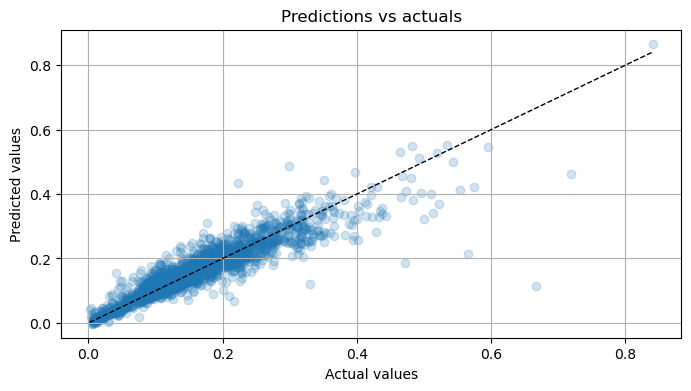

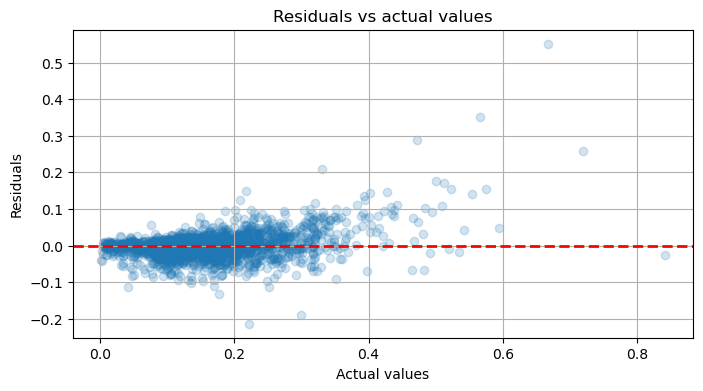

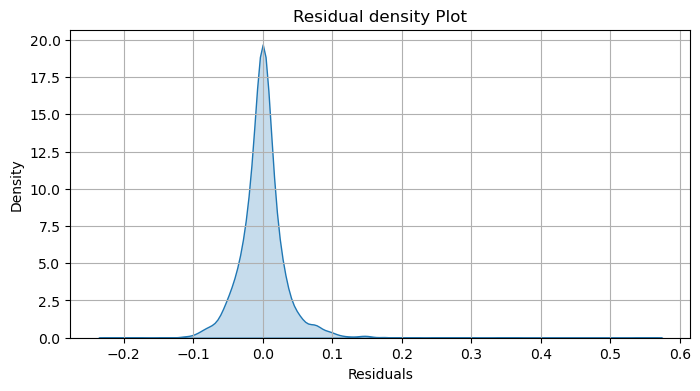

Shapiro-Wilk p-value: 0.0


In [320]:
# Select dependent variable
endog_var = ["TOC (mg/l C)"]

# Select explanatory variables / covariates
exog_var = [
    "Organic N (µg/l N)",
    "Fe (µg/l)",
    "Organic P (µg/l P)",
    "Na (mekv/l)",
]

# Group variable (always lake id)
groups_var = ["MD-MVM Id"]

# Drop rows that contain NaNs
df_cv = df_fill_nan[groups_var + endog_var + exog_var].dropna(axis="rows")

# Select columns for the model
y = df_cv["TOC (mg/l C)"]
X_fe = df_cv.drop("TOC (mg/l C)", axis="columns")

# Run train-test iterations
(
    df_output_train,
    df_output_test,
    models,
    avg_model,
    df_re_params,
    df_re_x_train,
    df_re_x_test,
) = run_multiple_train_test(X_fe=X_fe, y=y, re=None, num_iter=10)

# Plot how well the model performs
plot_train_test_results(df_output_test)

# Run Shapiro-Wilk normality test on residuals
residuals = df_output_test["Pred"] - df_output_test["Actual"]
res = shapiro(residuals)
print(f"Shapiro-Wilk p-value: {round(res[1], 3)}")

**Conclusion:** The initial model performs quite well, with an R2 of 0.844 an accuracy of 84.7%. Na is not statistically significant. Residuals are not normally distributed, but the density shape is still symmetric overall (like a very pointed normal distribution), with a bit of a right tail of outliers. In the second plot, we can also see that the residuals look mostly random, except for the few outliers to the right (explaining the right tail in the density plot). 

### Model 1.2: Lake chemistry with sequential feature elimination

In a more systematic fashion, we start with all the variables that are related to lake chemistry and perform a sequential feature elimination: One variable at a time is removed, until only variables that are significant at a 5% significance level, and lead to higher AIC / BIC scores, remain in the model.

In [135]:
# Select dependent variable
endog_var = ["TOC (mg/l C)"]

# Select explanatory variables / covariates
exog_var = [
    "C_phyll (µg/l)",
    "pH",
    "Cond_25 (mS/m)",
    "Alk/Acid (mekv/l)",
    "Ca (mekv/l)",
    "Mg (mekv/l)",
    "Na (mekv/l)",
    "K (mekv/l)",
    "SO4 (mekv/l)",
    "Cl (mekv/l)",
    "F (mekv/l)",
    "Si (mg/l)",
    "Fe (µg/l)",
    "Water temp (°C)",
    "Organic N (µg/l N)",
    "Inorganic N (µg/l N)",
    "Organic P (µg/l P)",
    "Inorganic P (µg/l P)",
]

# Group variable (always lake id)
groups_var = ["MD-MVM Id"]

# Drop rows that contain NaNs
df_cv = df_fill_nan[groups_var + endog_var + exog_var].dropna(axis="rows")

# Select columns for the model
y = df_cv[endog_var[0]]
X_fe = df_cv.drop(endog_var, axis="columns")
re = ["Organic N (µg/l N)", "SO4 (mekv/l)"]

# Run train-test iterations
select_var = sequential_feature_elimination(
    X_fe, y, re=None, num_iter=10, p_crit=0.025, info_crit=True
)
select_var

Removed K (mekv/l) based on p-value criterion (0.389)
Removed Cl (mekv/l) based on p-value criterion (0.577)
Removed Water temp (°C) based on p-value criterion (0.34)
Removed Inorganic N (µg/l N) based on p-value criterion (0.144)
Removed Ca (mekv/l) based on p-value criterion (0.628)
Removed Na (mekv/l) based on p-value criterion (0.645)
Removed Cond_25 (mS/m) based on p-value criterion (0.463)


['C_phyll (µg/l)',
 'pH',
 'Alk/Acid (mekv/l)',
 'Mg (mekv/l)',
 'F (mekv/l)',
 'Si (mg/l)',
 'Fe (µg/l)',
 'Organic N (µg/l N)',
 'Organic P (µg/l P)',
 'Inorganic P (µg/l P)',
 'SO4 (mekv/l)']


R2:
  Average: 0.866 (Train), 0.863 (Test)
  Minimum: 0.859 (Train), 0.844 (Test)
  Maximum: 0.873 (Train), 0.884 (Test)

MAE:
  Average: 0.021 (Train), 0.021 (Test)
  Minimum: 0.020 (Train), 0.020 (Test)
  Maximum: 0.024 (Train), 0.025 (Test)

Accuracy: 1 - (s)MAPE:
  Average: 0.846 (Train), 0.843 (Test)
  Minimum: 0.843 (Train), 0.836 (Test)
  Maximum: 0.849 (Train), 0.848 (Test)

Output summary of the most representative (average) model:

             Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   TOC (mg/l C)
No. Observations:   6608      Method:               REML        
No. Groups:         108       Scale:                0.0011      
Min. group size:    24        Log-Likelihood:       12644.1173  
Max. group size:    73        Converged:            Yes         
Mean group size:    61.2                                        
----------------------------------------------------------------
                     Coef.  Std.Err.    z    P>

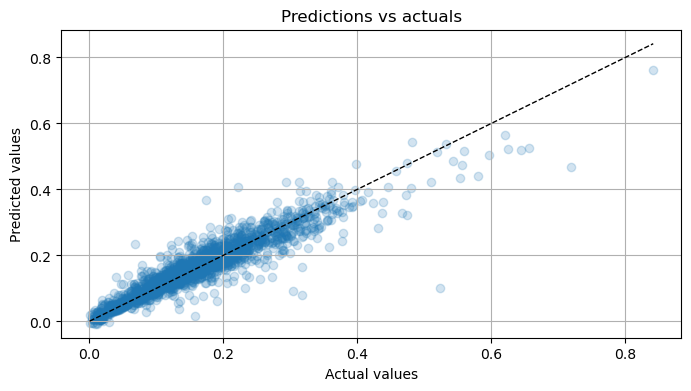

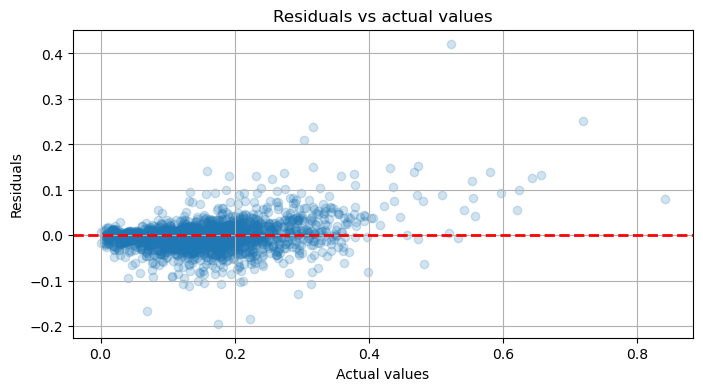

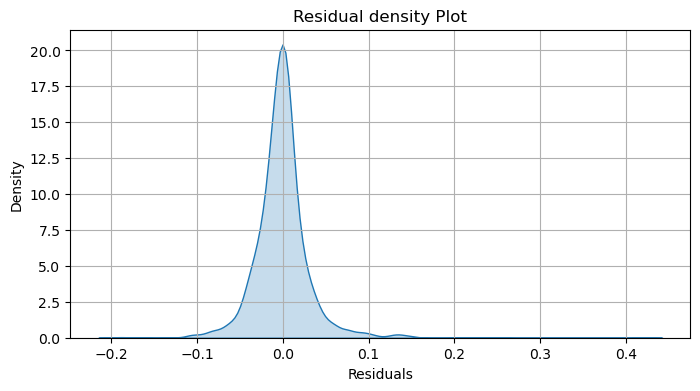

Shapiro-Wilk p-value: 0.0


In [321]:
# Select dependent variable
endog_var = ["TOC (mg/l C)"]

# Select explanatory variables / covariates
exog_var = [
    "C_phyll (µg/l)",
    "pH",
    "Alk/Acid (mekv/l)",
    "Mg (mekv/l)",
    "F (mekv/l)",
    "Si (mg/l)",
    "Fe (µg/l)",
    "Organic N (µg/l N)",
    "Organic P (µg/l P)",
    "Inorganic P (µg/l P)",
    "SO4 (mekv/l)",
]

# Group variable (always lake id)
groups_var = ["MD-MVM Id"]

# Drop rows that contain NaNs
df_cv = df_fill_nan[groups_var + endog_var + exog_var].dropna(axis="rows")

# Select columns for the model
y = df_cv["TOC (mg/l C)"]
X_fe = df_cv.drop("TOC (mg/l C)", axis="columns")

# Run train-test iterations
(
    df_output_train,
    df_output_test,
    models,
    avg_model,
    df_re_params,
    df_re_x_train,
    df_re_x_test,
) = run_multiple_train_test(X_fe=X_fe, y=y, re=None, num_iter=10)

# Plot how well the model performs
plot_train_test_results(df_output_test)

# Run Shapiro-Wilk normality test on residuals
residuals = df_output_test["Pred"] - df_output_test["Actual"]
res = shapiro(residuals)
print(f"Shapiro-Wilk p-value: {round(res[1], 3)}")

**Conclusion:** Compared to the first model, including these additional variables improves the model fit, from an R2 score of 0.844 to 0.863 on the test data. The accuracy, 1 - sMAPE, is actually slightly worse. MAE is reduced by more, from 0.023 to 0.021. Looking at the plots, it's clear that this larger model produces fewer predictions that are outliers compared to the actual TOC values.

### Model 1.3: Lake chemistry with random effects

The two models above only include a random intercept for each lake (which creates an offset for each lake compared to the population intercept). In the next step, we investigate if including a subset of the variables as random slopes (modifying the population coefficients) can improve model fit and predictive accuracy. We start with individual variables, then pairs. 

In [143]:
# List of variables with coefficients with absolute values >0.1
re_candidates = [
    "Mg (mekv/l)", 
    "Organic N (µg/l N)", 
    "SO4 (mekv/l)", 
    "C_phyll (µg/l)",
    "pH",
    "Si (mg/l)",
    "Fe (µg/l)",
]

res_dict = {}
benchmark_r2 = r2_score(df_output_test["Actual"], df_output_test["Pred"])

# Run train-test iterations
for re in re_candidates:
    (
        df_output_train,
        df_output_test,
        models,
        avg_model,
        df_re_params,
        df_re_x_train,
        df_re_x_test,
    ) = run_multiple_train_test(X_fe=X_fe, y=y, re=[re], num_iter=10, print_output=False)
    test_r2 = r2_score(df_output_test["Actual"], df_output_test["Pred"])
    res_dict[re] = round(test_r2 - benchmark_r2, 4)

print(res_dict)

{'Mg (mekv/l)': -0.0099, 'Organic N (µg/l N)': -0.0033, 'SO4 (mekv/l)': 0.0006, 'C_phyll (µg/l)': -0.0117, 'pH': 0.0036, 'Si (mg/l)': -0.0034, 'Fe (µg/l)': 0.0033}


In [155]:
# List of variables with coefficients with absolute values >0.1
re_candidate_pairs = [
    ["Mg (mekv/l)", "Organic N (µg/l N)"],
    ["Mg (mekv/l)", "SO4 (mekv/l)"],
    ["Mg (mekv/l)", "C_phyll (µg/l)"],
    ["Mg (mekv/l)", "pH"],
    ["Mg (mekv/l)", "Si (mg/l)"],
    ["Mg (mekv/l)", "Fe (µg/l)"],
    ["Organic N (µg/l N)", "SO4 (mekv/l)"],
    ["Organic N (µg/l N)", "pH"],
    ["Organic N (µg/l N)", "Si (mg/l)"],
    ["Organic N (µg/l N)", "Fe (µg/l)"],
    ["SO4 (mekv/l)", "C_phyll (µg/l)"],
    ["SO4 (mekv/l)", "pH"],
    ["SO4 (mekv/l)", "Si (mg/l)"],
    ["SO4 (mekv/l)", "Fe (µg/l)"],
    ["C_phyll (µg/l)", "pH"],
    ["C_phyll (µg/l)", "Si (mg/l)"],
    ["C_phyll (µg/l)", "Fe (µg/l)"],
    ["pH", "Si (mg/l)"],
    ["pH", "Fe (µg/l)"],
    ["Si (mg/l)", "Fe (µg/l)"],
]

res_dict = {}
benchmark_r2 = r2_score(df_output_test["Actual"], df_output_test["Pred"])

# Run train-test iterations
for re_pair in re_candidate_pairs:
    (
        df_output_train,
        df_output_test,
        models,
        avg_model,
        df_re_params,
        df_re_x_train,
        df_re_x_test,
    ) = run_multiple_train_test(X_fe=X_fe, y=y, re=re_pair, num_iter=10, print_output=False)
    test_r2 = r2_score(df_output_test["Actual"], df_output_test["Pred"])
    res_dict[re_pair[0], re_pair[1]] = round(test_r2 - benchmark_r2, 4)

print(res_dict)

{('Mg (mekv/l)', 'Organic N (µg/l N)'): 0.0184, ('Mg (mekv/l)', 'SO4 (mekv/l)'): 0.0253, ('Mg (mekv/l)', 'C_phyll (µg/l)'): 0.0106, ('Mg (mekv/l)', 'pH'): 0.0072, ('Mg (mekv/l)', 'Si (mg/l)'): 0.0178, ('Mg (mekv/l)', 'Fe (µg/l)'): 0.019, ('Organic N (µg/l N)', 'SO4 (mekv/l)'): 0.0216, ('Organic N (µg/l N)', 'pH'): 0.0218, ('Organic N (µg/l N)', 'Si (mg/l)'): 0.0122, ('Organic N (µg/l N)', 'Fe (µg/l)'): 0.0163, ('SO4 (mekv/l)', 'C_phyll (µg/l)'): 0.0205, ('SO4 (mekv/l)', 'pH'): 0.0302, ('SO4 (mekv/l)', 'Si (mg/l)'): 0.0032, ('SO4 (mekv/l)', 'Fe (µg/l)'): 0.0242, ('C_phyll (µg/l)', 'pH'): 0.0075, ('C_phyll (µg/l)', 'Si (mg/l)'): 0.0131, ('C_phyll (µg/l)', 'Fe (µg/l)'): 0.0093, ('pH', 'Si (mg/l)'): 0.0203, ('pH', 'Fe (µg/l)'): 0.0216, ('Si (mg/l)', 'Fe (µg/l)'): 0.0255}


**Conclusion:** Including just single-variable random effect slopes either reduces the model fit or only very marginally improves it. Some of the variable pairs have a larger effect, but it's not huge. In the model below, we include the pair which had the largest effect on R2. It does improve model fit and accuracy, but interestingly enough it also leads to some fixed effect coefficients becoming statistically non-significant.


R2:
  Average: 0.889 (Train), 0.881 (Test)
  Minimum: 0.883 (Train), 0.857 (Test)
  Maximum: 0.898 (Train), 0.899 (Test)

MAE:
  Average: 0.019 (Train), 0.020 (Test)
  Minimum: 0.018 (Train), 0.018 (Test)
  Maximum: 0.025 (Train), 0.026 (Test)

Accuracy: 1 - (s)MAPE:
  Average: 0.868 (Train), 0.864 (Test)
  Minimum: 0.866 (Train), 0.859 (Test)
  Maximum: 0.870 (Train), 0.867 (Test)

Output summary of the most representative (average) model:

                 Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     TOC (mg/l C)
No. Observations:      6608        Method:                 REML        
No. Groups:            108         Scale:                  0.0018      
Min. group size:       26          Log-Likelihood:         10998.3410  
Max. group size:       73          Converged:              Yes         
Mean group size:       61.2                                            
------------------------------------------------------------------

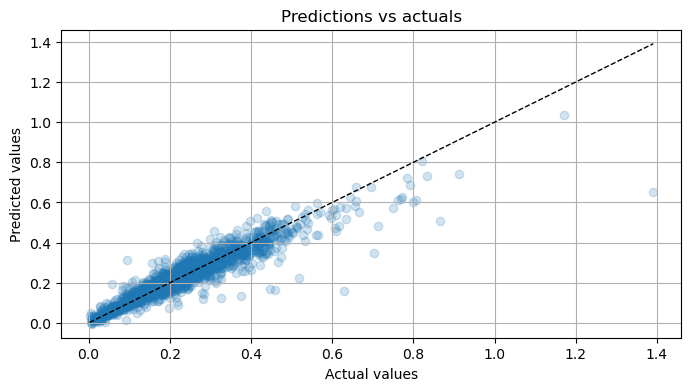

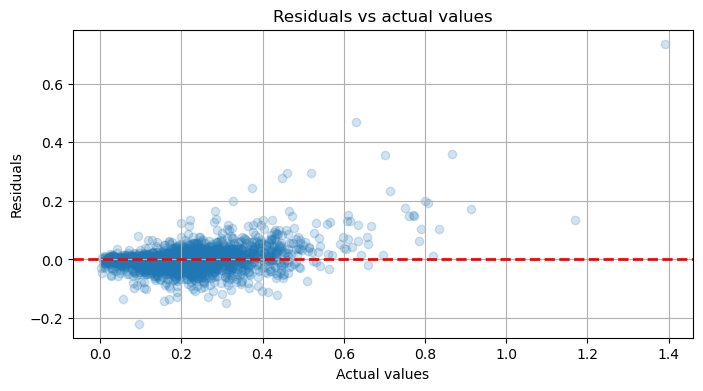

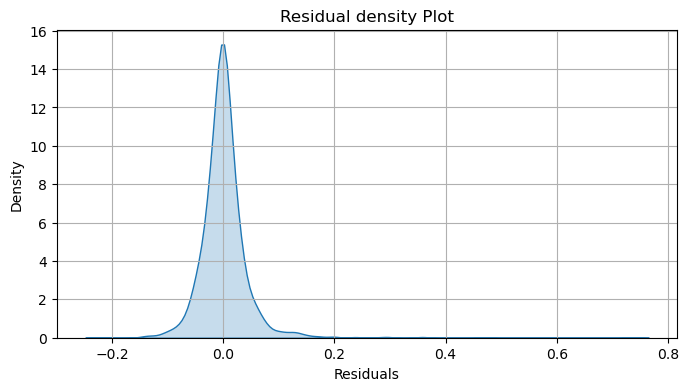

Shapiro-Wilk p-value: 0.0


In [322]:
# Select dependent variable
endog_var = ["TOC (mg/l C)"]

# Select explanatory variables / covariates
exog_var = [
    "C_phyll (µg/l)",
    "pH",
    "Alk/Acid (mekv/l)",
    "Mg (mekv/l)",
    "F (mekv/l)",
    "Si (mg/l)",
    "Fe (µg/l)",
    "Organic N (µg/l N)",
    "Organic P (µg/l P)",
    "Inorganic P (µg/l P)",
    "SO4 (mekv/l)",
]

# Group variable (always lake id)
groups_var = ["MD-MVM Id"]

# Drop rows that contain NaNs
df_cv = df_fill_nan[groups_var + endog_var + exog_var].dropna(axis="rows")

# Select columns for the model
y = df_cv["TOC (mg/l C)"]
X_fe = df_cv.drop("TOC (mg/l C)", axis="columns")
re = ['SO4 (mekv/l)', 'pH']

# Run train-test iterations
(
    df_output_train,
    df_output_test,
    models,
    avg_model,
    df_re_params,
    df_re_x_train,
    df_re_x_test,
) = run_multiple_train_test(X_fe=X_fe, y=y, re=re, num_iter=10)

# Plot how well the model performs
plot_train_test_results(df_output_test)

# Run Shapiro-Wilk normality test on residuals
residuals = df_output_test["Pred"] - df_output_test["Actual"]
res = shapiro(residuals)
print(f"Shapiro-Wilk p-value: {round(res[1], 3)}")

**Conclusion:** The model with RE included does lead to a substantial improvement in R2 and accuracy, by about 0.02 each.

**Lake-level analysis:** In the plots below, we can visualize predictions vs actuals and differences in slopes (coefficients) between lakes.

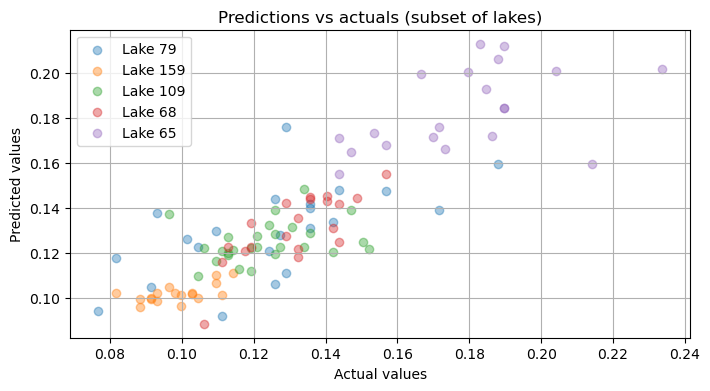

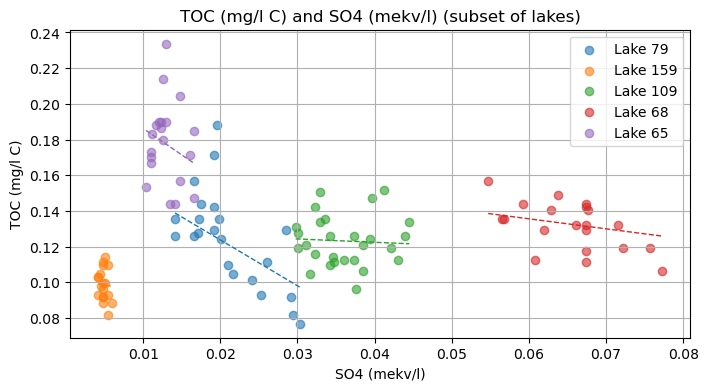

In [165]:
# Visualize random effects for group of lakes
lake_subset = list(np.random.choice(df_output_test["Lake"].unique(), 5))

# Predicted values and actuals for subset of lakes
plot_lake_subset_results(df_output_test, lake_subset)

# Visualize differences in slopes
plot_lake_intercept_slope(
    df_output_test, df_re_params, df_re_x_test, "SO4 (mekv/l)", avg_model, lake_subset
)

### Model 1.4: Lake chemistry with variable transformations

We now apply the variable transformations suggested in the data analysis notebook, to make the relationships between TOC and covariates more linear. For some variables, this implies a log transformation. For others, we first take the log, then do a power transformation. We then run feature selection as normal and train a model with the selected features.

In [148]:
# Variables that should be log transformed
log_var = [
    "C_phyll (µg/l)",
    "Si (mg/l)",
    "Fe (µg/l)",
    'Organic N (µg/l N)',
    'Inorganic N (µg/l N)',
    'Organic P (µg/l N)',
    'Inorganic P (µg/l N)',
]

# First log, then power transformation for these variables
log_cube_var = [
    "Fe (µg/l)", 
    'Organic N (µg/l N)', 
    'Inorganic P (µg/l P)'
]

In [153]:
# Select dependent variable
endog_var = ["TOC (mg/l C)"]

# Select explanatory variables / covariates
exog_var = [
    "C_phyll (µg/l)",
    "pH",
    "Cond_25 (mS/m)",
    "Alk/Acid (mekv/l)",
    "Ca (mekv/l)",
    "Mg (mekv/l)",
    "Na (mekv/l)",
    "K (mekv/l)",
    "SO4 (mekv/l)",
    "Cl (mekv/l)",
    "F (mekv/l)",
    "Si (mg/l)",
    "Fe (µg/l)",
    "Water temp (°C)",
    "Organic N (µg/l N)",
    "Inorganic N (µg/l N)",
    "Organic P (µg/l P)",
    "Inorganic P (µg/l P)",
]

# Group variable (always lake id)
groups_var = ["MD-MVM Id"]

# Drop rows that contain NaNs
df_cv = df_fill_nan[groups_var + endog_var + exog_var].dropna(axis="rows")

# Perform variable transformations
for col in df_cv.columns:
    if col in log_var:
        df_cv[col] = np.log(df_cv[col]).replace([np.inf, -np.inf], 0)
    elif col in log_cube_var:
        df_cv[col] = np.power(np.log(df_cv[col]), 3).replace([np.inf, -np.inf], 0)

# Select columns for the model
y = df_cv[endog_var[0]]
X_fe = df_cv.drop(endog_var, axis="columns")

# Run train-test iterations
select_var = sequential_feature_elimination(
    X_fe, y, re=None, num_iter=10, p_crit=0.025, info_crit=True
)
select_var

/Users/jakobnystrom/anaconda3/envs/watersheds/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Removed K (mekv/l) based on p-value criterion (0.648)
Removed Cl (mekv/l) based on p-value criterion (0.45)
Removed Organic P (µg/l P) based on p-value criterion (0.477)
Removed Inorganic N (µg/l N) based on p-value criterion (0.153)
Removed Cond_25 (mS/m) based on p-value criterion (0.557)
Removed Ca (mekv/l) based on p-value criterion (0.297)
Removed Alk/Acid (mekv/l) based on p-value criterion (0.119)
Removed Na (mekv/l) based on p-value criterion (0.181)


['C_phyll (µg/l)',
 'pH',
 'Mg (mekv/l)',
 'F (mekv/l)',
 'Si (mg/l)',
 'Fe (µg/l)',
 'Water temp (°C)',
 'Organic N (µg/l N)',
 'Inorganic P (µg/l P)',
 'SO4 (mekv/l)']


R2:
  Average: 0.868 (Train), 0.855 (Test)
  Minimum: 0.864 (Train), 0.839 (Test)
  Maximum: 0.874 (Train), 0.868 (Test)

MAE:
  Average: 0.021 (Train), 0.022 (Test)
  Minimum: 0.020 (Train), 0.020 (Test)
  Maximum: 0.024 (Train), 0.026 (Test)

Accuracy: 1 - (s)MAPE:
  Average: 0.847 (Train), 0.844 (Test)
  Minimum: 0.845 (Train), 0.837 (Test)
  Maximum: 0.848 (Train), 0.853 (Test)

Output summary of the most representative (average) model:

             Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   TOC (mg/l C)
No. Observations:   6608      Method:               REML        
No. Groups:         108       Scale:                0.0011      
Min. group size:    18        Log-Likelihood:       12711.2722  
Max. group size:    72        Converged:            Yes         
Mean group size:    61.2                                        
----------------------------------------------------------------
                     Coef.  Std.Err.    z    P>

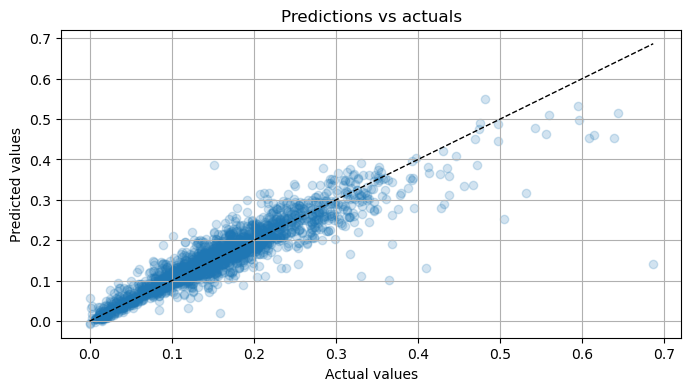

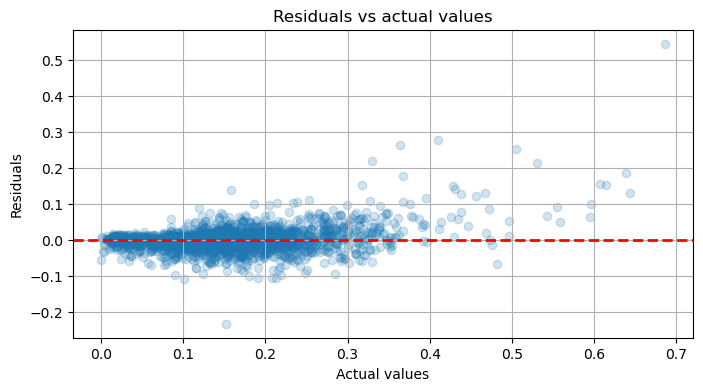

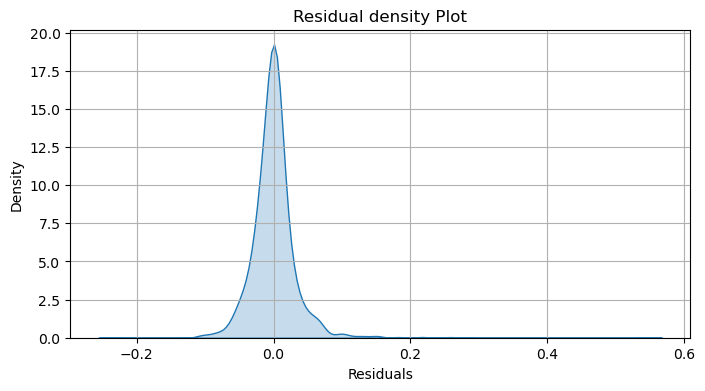

p-value: 0.0


In [154]:
# Select dependent variable
endog_var = ["TOC (mg/l C)"]

# Select explanatory variables / covariates
exog_var = [
    "C_phyll (µg/l)",
    "pH",
    "Mg (mekv/l)",
    "F (mekv/l)",
    "Si (mg/l)",
    "Fe (µg/l)",
    'Water temp (°C)',
    "Organic N (µg/l N)",
    "Inorganic P (µg/l P)",
    "SO4 (mekv/l)",
]

# Group variable (always lake id)
groups_var = ["MD-MVM Id"]

# Drop rows that contain NaNs
df_cv = df_fill_nan[groups_var + endog_var + exog_var].dropna(axis="rows")

# Select columns for the model
y = df_cv["TOC (mg/l C)"]
X_fe = df_cv.drop("TOC (mg/l C)", axis="columns")

# Run train-test iterations
(
    df_output_train,
    df_output_test,
    models,
    df_re_params,
    df_re_x_train,
    df_re_x_test,
) = run_multiple_train_test(X_fe=X_fe, y=y, re=None, num_iter=10)

# Plot how well the model performs
plot_train_test_results(df_output_test)

# Run Shapiro-Wilk normality test on residuals
residuals = df_output_test["Pred"] - df_output_test["Actual"]
res = shapiro(residuals)
print(f"Shapiro-Wilk p-value: {round(res[1], 3)}")

**Conclusion:** Variable transformations lead to a similar, but not identical selection of variables. The performance of this model is slightly worse than Model 1.2, with some more outlier predictions, likely because the analysis of the form of relationships was done on the population level, indicating this doesn't hold true when going down to individual lake level.

### Model 1.1-1.4: Correlation between variables

We plot the correlation heatmap of the variables in Model 1.2. Ideally, correlation between explanatory variables should be as close to 0 as possible. Since we are evaluating this in the context of a linear model, we use Pearson correlation, which assumes linear relationships between variables. Indeed, most correlation coefficients are quite low (<0.3). The ones that are higher are Chlorophyll-Organic N and Chlorophyll-Organic P.

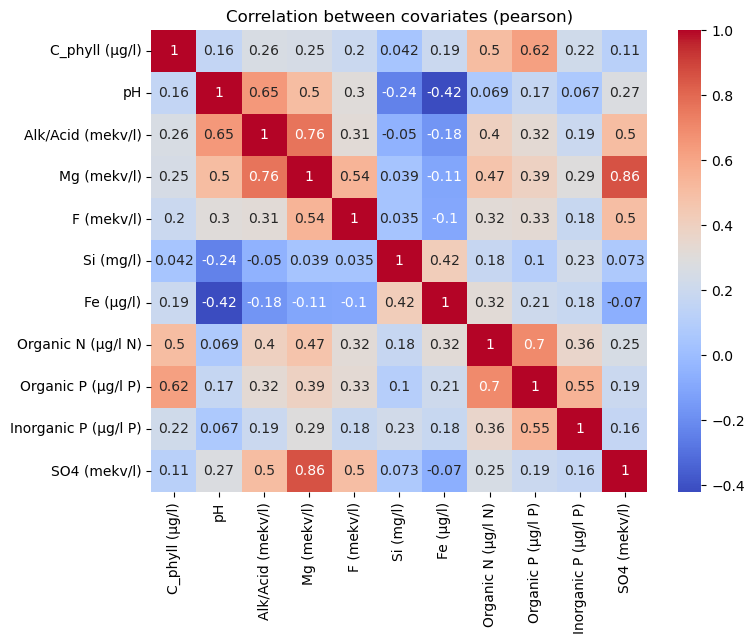

In [166]:
features = [
    "C_phyll (µg/l)",
    "pH",
    "Alk/Acid (mekv/l)",
    "Mg (mekv/l)",
    "F (mekv/l)",
    "Si (mg/l)",
    "Fe (µg/l)",
    "Organic N (µg/l N)",
    "Organic P (µg/l P)",
    "Inorganic P (µg/l P)",
    "SO4 (mekv/l)",
]
create_corr_heatmap(df_fill_nan, features, method="pearson")

### Model 2.1: Catchment area, weather and water flows

In this model, we include a different set of variables that are not overlapping with Models 1-2. This includes attributes of the lake and catchment area, temperature, precipitation, and water flow and residence time. It should be noted that lake and catchment attributes are fixed over time, so there is less variation compared to the panel data in the first model version. The catchment area variables are expressed in % of total land area, e.g. % of land that is forest. WRT is only available for about 29% of the samples.

In [222]:
# Select dependent variable
endog_var = ["TOC (mg/l C)"]

# Select explanatory variables / covariates
exog_var = [
    "Altitude",
    "Latitude",
    "Longitude",
    "Forest",
    "Water",
    "Wetland",
    "Clearing",
    "Open land",
    "Agriculture",
    "Mountains",
    "Urban area",
    "WRT",
    "Temp 1w avg",
    "Temp 2w avg",
    "Temp 4w avg",
    "Temp 12w avg",
    "Temp 52w avg",
    "Precip 1w avg",
    "Precip 2w avg",
    "Precip 4w avg",
    "Precip 12w avg",
    "Precip 52w avg",
]

# Group variable (always lake id)
groups_var = ["MD-MVM Id"]

# Drop rows that contain NaNs
df_cv = df_fill_nan[groups_var + endog_var + exog_var].dropna(axis="rows").replace(
    [np.inf, -np.inf], 0
)

# Select columns for the model
y = df_cv[endog_var[0]]
X_fe = df_cv.drop(endog_var, axis="columns")

# Run train-test iterations
select_var = sequential_feature_elimination(X_fe, y, re=None, num_iter=10, p_crit=0.025, info_crit=True)
select_var

Removed Open land based on p-value criterion (0.98)
Removed WRT based on p-value criterion (0.728)
Removed Precip 1w avg based on p-value criterion (0.631)
Removed Temp 1w avg based on p-value criterion (0.537)
Removed Water based on p-value criterion (0.444)
Removed Urban area based on p-value criterion (0.45)
Removed Temp 4w avg based on p-value criterion (0.138)
Removed Temp 12w avg based on p-value criterion (0.48)
Removed Precip 12w avg based on p-value criterion (0.151)
Removed Clearing based on p-value criterion (0.099)
Removed Precip 2w avg based on p-value criterion (0.084)
Removed Longitude based on p-value criterion (0.045)
Removed Latitude based on p-value criterion (0.375)
Removed Mountains based on p-value criterion (0.45)
Removed Wetland based on p-value criterion (0.209)


['Forest',
 'Agriculture',
 'Temp 2w avg',
 'Temp 52w avg',
 'Precip 4w avg',
 'Precip 52w avg',
 'Altitude']


R2:
  Average: 0.810 (Train), 0.792 (Test)
  Minimum: 0.802 (Train), 0.770 (Test)
  Maximum: 0.817 (Train), 0.819 (Test)

MAE:
  Average: 0.026 (Train), 0.027 (Test)
  Minimum: 0.024 (Train), 0.024 (Test)
  Maximum: 0.034 (Train), 0.035 (Test)

Accuracy: 1 - (s)MAPE:
  Average: 0.830 (Train), 0.828 (Test)
  Minimum: 0.829 (Train), 0.822 (Test)
  Maximum: 0.833 (Train), 0.835 (Test)

Output summary of the most representative (average) model:

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: TOC (mg/l C)
No. Observations: 6523    Method:             REML        
No. Groups:       107     Scale:              0.0016      
Min. group size:  24      Log-Likelihood:     11453.9673  
Max. group size:  72      Converged:          Yes         
Mean group size:  61.0                                    
----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------

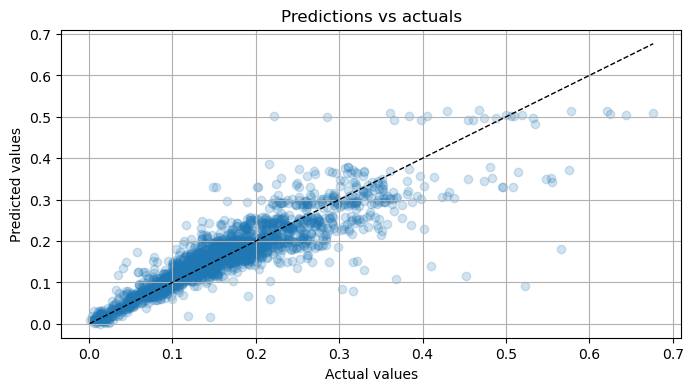

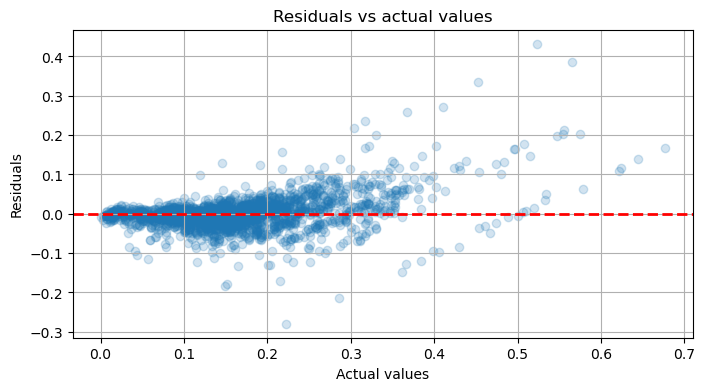

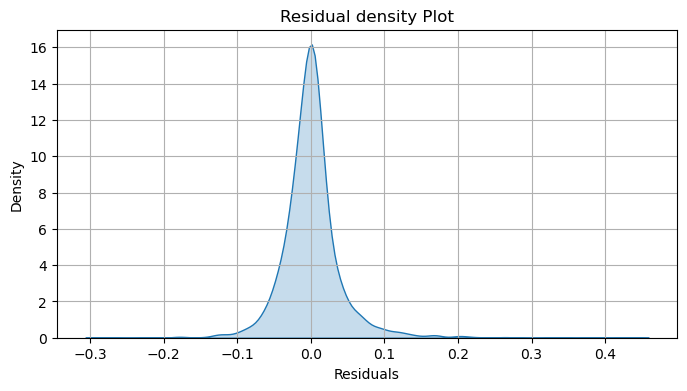

Shapiro-Wilk p-value: 0.0


In [230]:
# Select dependent variable
endog_var = ["TOC (mg/l C)"]

# Select explanatory variables / covariates
exog_var = [
    'Forest',
    'Agriculture',
    'Temp 2w avg',
    'Temp 52w avg',
    'Precip 4w avg',
    'Precip 52w avg',
    'Altitude'
]

# Group variable (always lake id)
groups_var = ["MD-MVM Id"]

# Drop rows that contain NaNs
df_cv = df_fill_nan[groups_var + endog_var + exog_var].dropna(axis="rows").replace(
    [np.inf, -np.inf], 0
)

# Select columns for the model
y = df_cv["TOC (mg/l C)"]
X_fe = df_cv.drop("TOC (mg/l C)", axis="columns")

# Run train-test iterations
(
    df_output_train,
    df_output_test,
    models,
    avg_model,
    df_re_params,
    df_re_x_train,
    df_re_x_test,
) = run_multiple_train_test(X_fe=X_fe, y=y, re=None, num_iter=10)

# Plot how well the model performs
plot_train_test_results(df_output_test)

# Run Shapiro-Wilk normality test on residuals
residuals = df_output_test["Pred"] - df_output_test["Actual"]
res = shapiro(residuals)
print(f"Shapiro-Wilk p-value: {round(res[1], 3)}")

**Conclusion:** Compared to the lake chemistry data, these variables explain considerably less of the variation in the data and leads to larger residuals.

### Model 2.2: Only catchment area and constant lake properties

A subset of the variables in Model 2.1. Since we only have one observation per lake on the share of catchment area types, we calculate the average TOC levels in the lake chemistry data set and use only one observation per lake for this model. This should be an OK approximation, since land use percentages are unlikely to change a lot over time. Since we now have a set of i.i.d. data, we use standard OLS regression. The sequential feature selection is done manually, since the evaluation pipeline above is tailored to the LME models. Since there are so few observations (110 lakes), the model below is fitted on the entire data set, and we visualize predictions made on that training set. 

In [297]:
# Select explanatory variables / covariates
catchment_features = [
    "Altitude",
    "Latitude",
    "Longitude",
    "Forest",
    "Water",
    "Wetland",
    "Clearing",
    "Open land",
    "Agriculture",
    "Mountains",
    "Urban area",
]

# Calculate per-group average for TOC and keep one row per group
df_avg = df_fill_nan.groupby("MD-MVM Id").agg({
    "TOC (mg/l C)": "mean",
    **{col: "first" for col in catchment_features}
}).reset_index().rename(columns={"TOC (mg/l C)": "Avg TOC (mg/l C)"})

                            OLS Regression Results                            
Dep. Variable:       Avg TOC (mg/l C)   R-squared:                       0.600
Model:                            OLS   Adj. R-squared:                  0.577
Method:                 Least Squares   F-statistic:                     25.79
Date:                Sun, 17 Dec 2023   Prob (F-statistic):           1.59e-18
Time:                        21:23:51   Log-Likelihood:                 85.697
No. Observations:                 110   AIC:                            -157.4
Df Residuals:                     103   BIC:                            -138.5
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Latitude       -0.4991      0.070     -7.168      

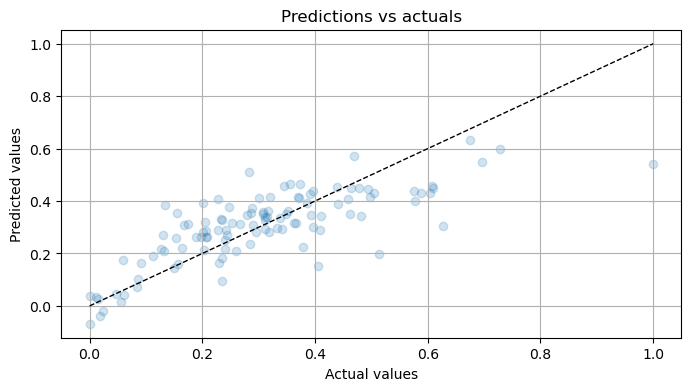

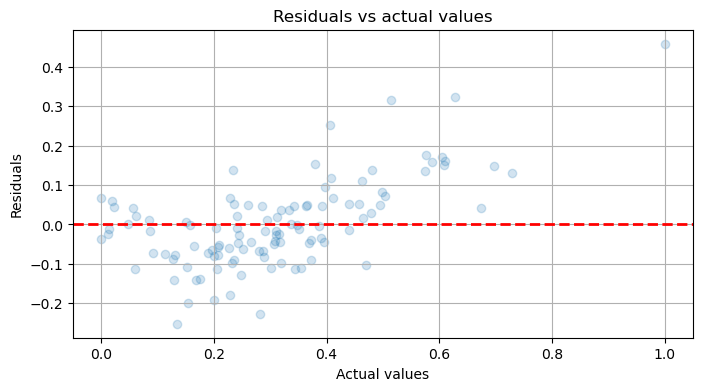

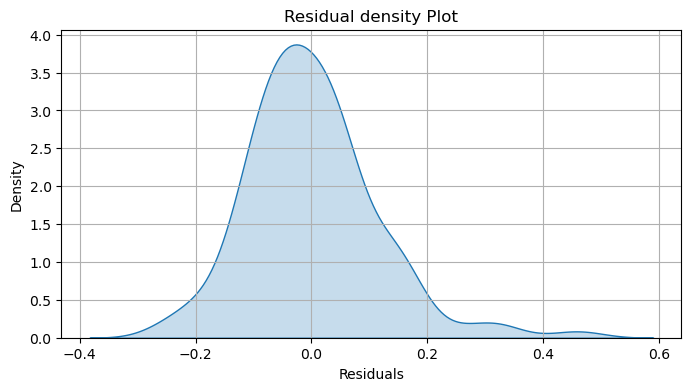

In [319]:
exog_var = [
    #"Altitude",
    "Latitude",
    "Longitude",
    "Forest",
    "Water",
    "Wetland",
    #"Clearing",
    #"Open land",
    "Agriculture",
    "Mountains",
    #"Urban area",
]

# Create train and test sets
Y = df_avg["Avg TOC (mg/l C)"]
X = df_avg[exog_var]
#x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)

# Perform data scaling
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
x_scaled = x_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(Y.values.reshape(-1, 1))
#x_train_scaled = x_scaler.fit_transform(x_train)
#x_test_scaled = x_scaler.transform(x_test)
#y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
#y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1))

# Fit the OLS model and make predictions
lr = sm.regression.linear_model.OLS(
    endog=pd.Series(y_scaled.ravel(), name=Y.name), 
    exog=pd.DataFrame(x_scaled, columns=X.columns), 
    missing='none', 
    hasconst=True,
)
lr_fit = lr.fit()
pred = lr_fit.predict(x_scaled)
df_output_test = pd.DataFrame({"Pred": pred.ravel(), "Actual": y_scaled.ravel()}) 

print(lr_fit.summary())

# Plot how well the model performs
plot_train_test_results(df_output_test)

**Conclusion:** The focus of this model evaluation is on the significant variables and model coefficients. The R2 and prediction-actual plots are not really comparable to the previous models, since we don't have any variation over time and there are so few observations. The lake-level intercept is a great boost to the performance in the other models.

### Model 2.3: Only weather (temp and precipitation)

In [234]:
# Select dependent variable
endog_var = ["TOC (mg/l C)"]

# Select explanatory variables / covariates
exog_var = [
    "Temp 1w avg",
    "Temp 2w avg",
    "Temp 4w avg",
    "Temp 12w avg",
    "Temp 52w avg",
    "Precip 1w avg",
    "Precip 2w avg",
    "Precip 4w avg",
    "Precip 12w avg",
    "Precip 52w avg",
]

# Group variable (always lake id)
groups_var = ["MD-MVM Id"]

# Drop rows that contain NaNs
df_cv = df_fill_nan[groups_var + endog_var + exog_var].dropna(axis="rows").replace(
    [np.inf, -np.inf], 0
)

# Select columns for the model
y = df_cv[endog_var[0]]
X_fe = df_cv.drop(endog_var, axis="columns")

# Run train-test iterations
select_var = sequential_feature_elimination(X_fe, y, re=None, num_iter=10, p_crit=0.025, info_crit=True)
select_var

Removed Temp 4w avg based on p-value criterion (0.657)
Removed Temp 12w avg based on p-value criterion (0.6)
Removed Temp 1w avg based on p-value criterion (0.758)
Removed Precip 4w avg based on p-value criterion (0.459)
Removed Precip 1w avg based on p-value criterion (0.447)


['Temp 52w avg',
 'Precip 2w avg',
 'Precip 12w avg',
 'Precip 52w avg',
 'Temp 2w avg']


R2:
  Average: 0.809 (Train), 0.803 (Test)
  Minimum: 0.803 (Train), 0.790 (Test)
  Maximum: 0.813 (Train), 0.822 (Test)

MAE:
  Average: 0.025 (Train), 0.025 (Test)
  Minimum: 0.025 (Train), 0.024 (Test)
  Maximum: 0.025 (Train), 0.026 (Test)

Accuracy: 1 - (s)MAPE:
  Average: 0.826 (Train), 0.824 (Test)
  Minimum: 0.823 (Train), 0.819 (Test)
  Maximum: 0.828 (Train), 0.830 (Test)

Output summary of the most representative (average) model:

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: TOC (mg/l C)
No. Observations: 6523    Method:             REML        
No. Groups:       107     Scale:              0.0016      
Min. group size:  25      Log-Likelihood:     11295.1264  
Max. group size:  73      Converged:          Yes         
Mean group size:  61.0                                    
----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------

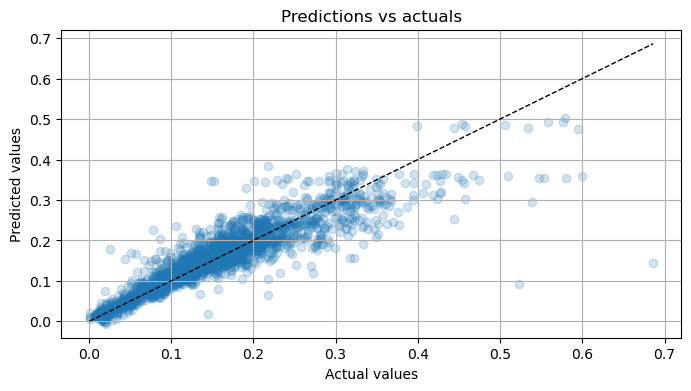

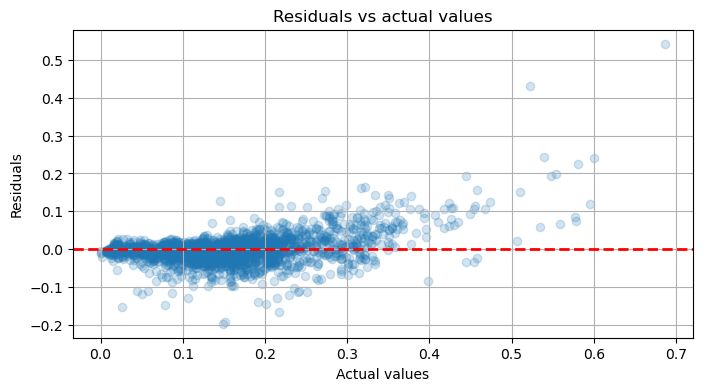

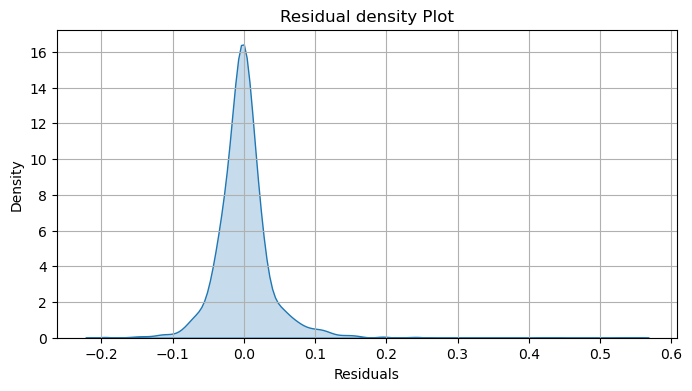

Shapiro-Wilk p-value: 0.0


In [323]:
# Select dependent variable
endog_var = ["TOC (mg/l C)"]

# Select explanatory variables / covariates
exog_var = [
    'Temp 52w avg',
    'Precip 2w avg',
    'Precip 12w avg',
    'Precip 52w avg',
    'Temp 2w avg'
]

# Group variable (always lake id)
groups_var = ["MD-MVM Id"]

# Drop rows that contain NaNs
df_cv = df_fill_nan[groups_var + endog_var + exog_var].dropna(axis="rows").replace(
    [np.inf, -np.inf], 0
)

# Select columns for the model
y = df_cv["TOC (mg/l C)"]
X_fe = df_cv.drop("TOC (mg/l C)", axis="columns")

# Run train-test iterations
(
    df_output_train,
    df_output_test,
    models,
    avg_model,
    df_re_params,
    df_re_x_train,
    df_re_x_test,
) = run_multiple_train_test(X_fe=X_fe, y=y, re=None, num_iter=10)

# Plot how well the model performs
plot_train_test_results(df_output_test)

# Run Shapiro-Wilk normality test on residuals
residuals = df_output_test["Pred"] - df_output_test["Actual"]
res = shapiro(residuals)
print(f"Shapiro-Wilk p-value: {round(res[1], 3)}")

**Conclusion:** R2 is on par with the catchment area model (Model 2.2), but accuracy a few percentage points worse.

### Model 2.4: Only water residence time (WRT)


R2:
  Average: 0.861 (Train), 0.849 (Test)
  Minimum: 0.853 (Train), 0.813 (Test)
  Maximum: 0.867 (Train), 0.876 (Test)

MAE:
  Average: 0.032 (Train), 0.033 (Test)
  Minimum: 0.031 (Train), 0.031 (Test)
  Maximum: 0.034 (Train), 0.036 (Test)

Accuracy: 1 - (s)MAPE:
  Average: 0.860 (Train), 0.856 (Test)
  Minimum: 0.857 (Train), 0.846 (Test)
  Maximum: 0.864 (Train), 0.866 (Test)

Output summary of the most representative (average) model:

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: TOC (mg/l C)
No. Observations: 1932    Method:             REML        
No. Groups:       56      Scale:              0.0030      
Min. group size:  1       Log-Likelihood:     2674.9413   
Max. group size:  43      Converged:          Yes         
Mean group size:  34.5                                    
-----------------------------------------------------------
            Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------

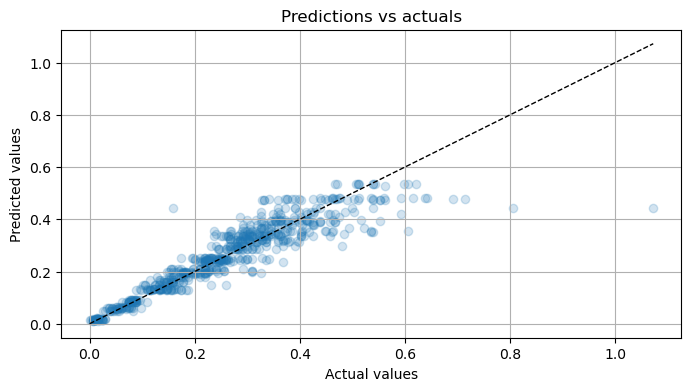

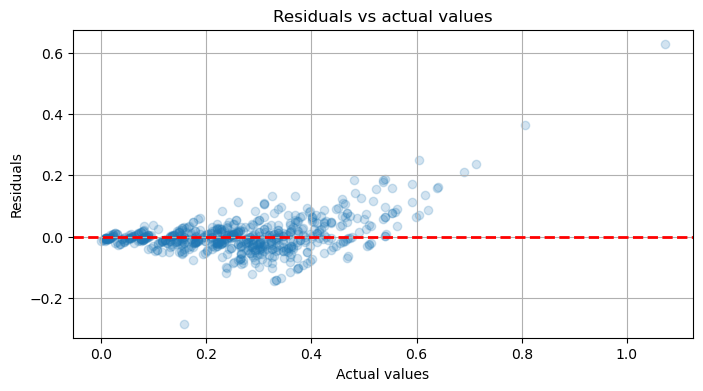

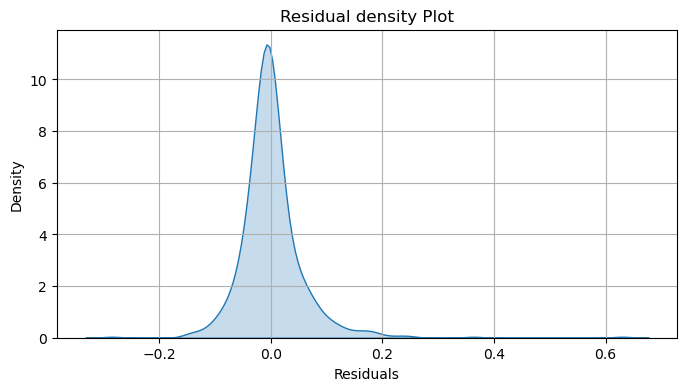

Shapiro-Wilk p-value: 0.0


In [324]:
# Select dependent variable
endog_var = ["TOC (mg/l C)"]

# Select explanatory variables / covariates
exog_var = ["WRT"]

# Group variable (always lake id)
groups_var = ["MD-MVM Id"]

# Drop rows that contain NaNs
df_cv = df_fill_nan[groups_var + endog_var + exog_var].dropna(axis="rows").replace(
    [np.inf, -np.inf], 0
)

# Select columns for the model
y = df_cv["TOC (mg/l C)"]
X_fe = df_cv.drop("TOC (mg/l C)", axis="columns")

# Run train-test iterations
(
    df_output_train,
    df_output_test,
    models,
    avg_model,
    df_re_params,
    df_re_x_train,
    df_re_x_test,
) = run_multiple_train_test(X_fe=X_fe, y=y, re=None, num_iter=10)

# Plot how well the model performs
plot_train_test_results(df_output_test)

# Run Shapiro-Wilk normality test on residuals
residuals = df_output_test["Pred"] - df_output_test["Actual"]
res = shapiro(residuals)
print(f"Shapiro-Wilk p-value: {round(res[1], 3)}")

**Conclusion:** The WRT variable is not statistically significant, but the model has surprisingly high R2 and accuracy. I can't think of any intuitive explanation for this right now. These results should be interpreted with caution, since there is only data on WRT for about 29% of the samples.

### Models 2.1-2.4: Correlation between variables

Ideally, correlation between explanatory variables should be as close to 0 as possible. Since we are evaluating this in the context of a linear model, we use Pearson correlation, which assumes linear relationships between variables. Indeed, most correlation coefficients are quite low (<0.3-0.4). The ones that are higher are Altitude-Forest.

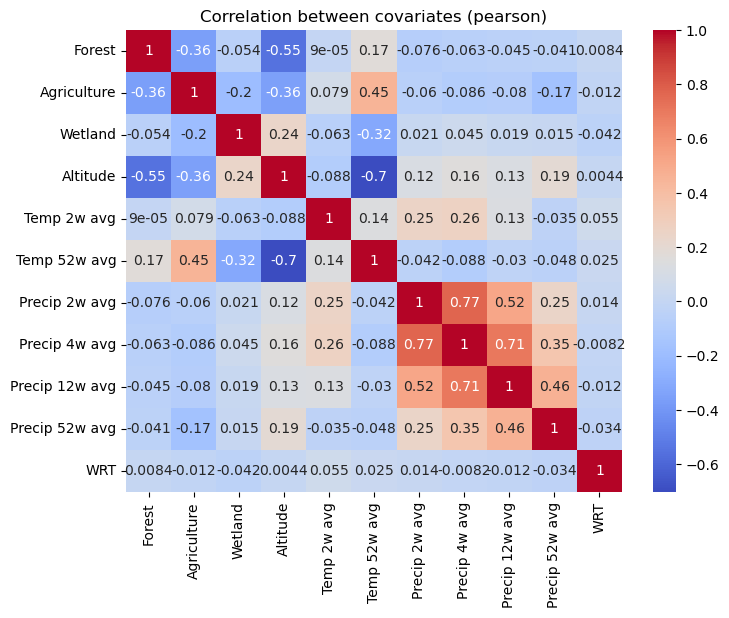

In [239]:
features = [
    'Forest',
    'Agriculture',
    "Wetland",
    'Altitude',
    'Temp 2w avg',
    'Temp 52w avg',
    'Precip 2w avg',
    'Precip 4w avg',
    'Precip 12w avg',
    'Precip 52w avg',
    "WRT",
]
create_corr_heatmap(df_fill_nan, features, method="pearson")

### Model 3.1: Seasonal and time variables 

Next we specify a model that just looks at the effect of seasonality, and time / trend from the start of the panel data until now. Note that only 3 out of 4 seasonal variables can be included, as we need a baseline against which to evaluate the effect. Since there are so few variables, we don't run the sequential feature selection.


R2:
  Average: 0.808 (Train), 0.801 (Test)
  Minimum: 0.800 (Train), 0.764 (Test)
  Maximum: 0.821 (Train), 0.826 (Test)

MAE:
  Average: 0.026 (Train), 0.026 (Test)
  Minimum: 0.024 (Train), 0.024 (Test)
  Maximum: 0.029 (Train), 0.031 (Test)

Accuracy: 1 - (s)MAPE:
  Average: 0.827 (Train), 0.823 (Test)
  Minimum: 0.824 (Train), 0.817 (Test)
  Maximum: 0.830 (Train), 0.828 (Test)

Output summary of the most representative (average) model:

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: TOC (mg/l C)
No. Observations: 6686    Method:             REML        
No. Groups:       110     Scale:              0.0016      
Min. group size:  26      Log-Likelihood:     11635.6468  
Max. group size:  73      Converged:          Yes         
Mean group size:  60.8                                    
-----------------------------------------------------------
            Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------

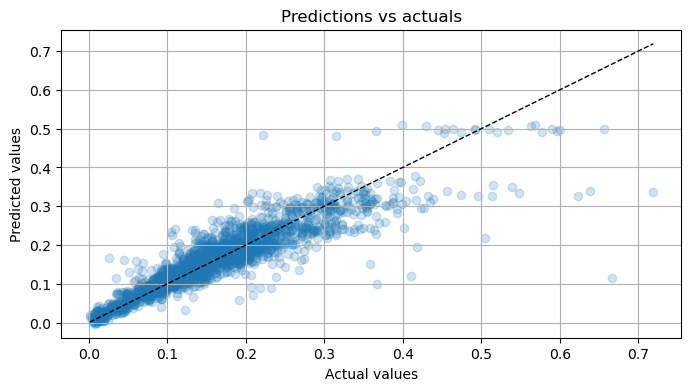

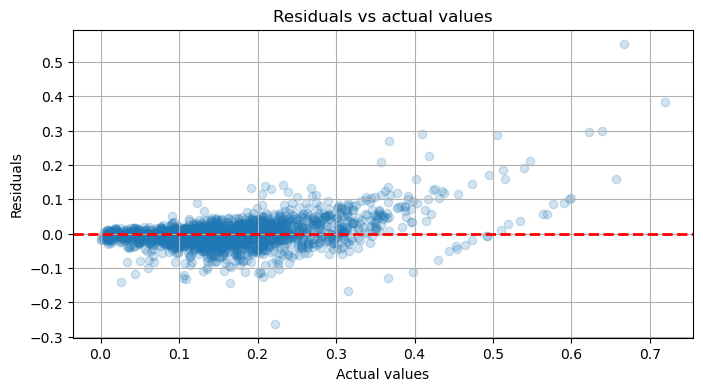

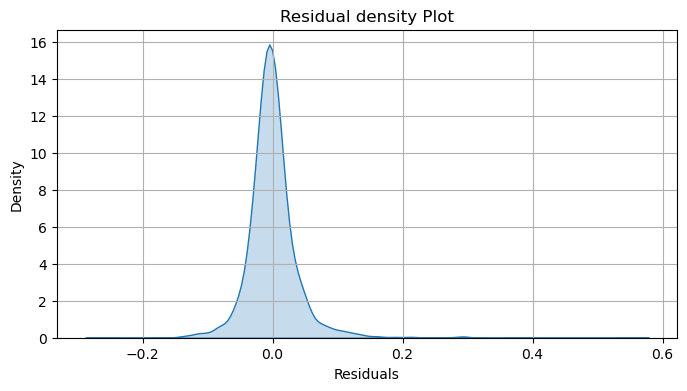

p-value: 0.0


In [306]:
# Select dependent variable
endog_var = ["TOC (mg/l C)"]

# Select explanatory variables / covariates
exog_var = ["Winter", 'Summer', 'Time count', 'Spring']

# Group variable (always lake id)
groups_var = ["MD-MVM Id"]

# Drop rows that contain NaNs
df_cv = df_fill_nan[groups_var + endog_var + exog_var].dropna(axis="rows")

# Select columns for the model
y = df_cv["TOC (mg/l C)"]
X_fe = df_cv.drop("TOC (mg/l C)", axis="columns")

# Run train-test iterations
(
    df_output_train,
    df_output_test,
    models,
    avg_model,
    df_re_params,
    df_re_x_train,
    df_re_x_test,
) = run_multiple_train_test(X_fe=X_fe, y=y, re=None, num_iter=10)

# Plot how well the model performs
plot_train_test_results(df_output_test)

# Run Shapiro-Wilk normality test on residuals
residuals = df_output_test["Pred"] - df_output_test["Actual"]
res = shapiro(residuals)
print(f"p-value: {round(res[1], 3)}")

### Model 3.2: Seasonal and time variables with random effects

Since we suspect trends will be lake-specific, and the seasonal effect dependent on the latitude of the lake, we try including random effects for these variables.


R2:
  Average: 0.816 (Train), 0.814 (Test)
  Minimum: 0.810 (Train), 0.792 (Test)
  Maximum: 0.823 (Train), 0.834 (Test)

MAE:
  Average: 0.026 (Train), 0.026 (Test)
  Minimum: 0.024 (Train), 0.024 (Test)
  Maximum: 0.033 (Train), 0.034 (Test)

Accuracy: 1 - (s)MAPE:
  Average: 0.839 (Train), 0.837 (Test)
  Minimum: 0.838 (Train), 0.833 (Test)
  Maximum: 0.841 (Train), 0.842 (Test)

Output summary of the most representative (average) model:

                Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    TOC (mg/l C)
No. Observations:      6686       Method:                REML        
No. Groups:            110        Scale:                 0.0022      
Min. group size:       24         Log-Likelihood:        10448.6357  
Max. group size:       74         Converged:             Yes         
Mean group size:       60.8                                          
---------------------------------------------------------------------
         

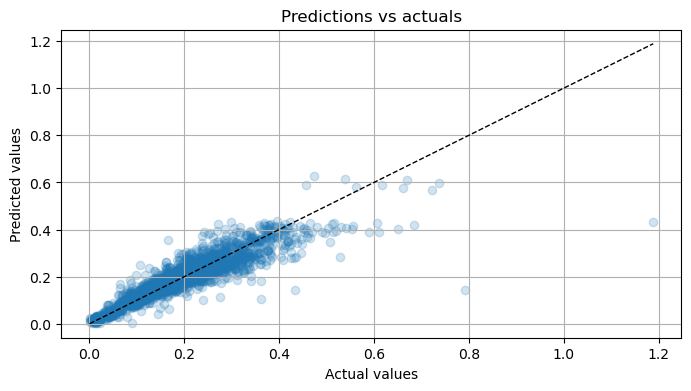

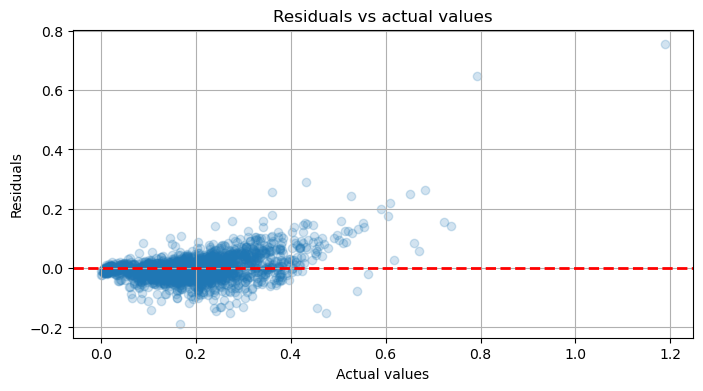

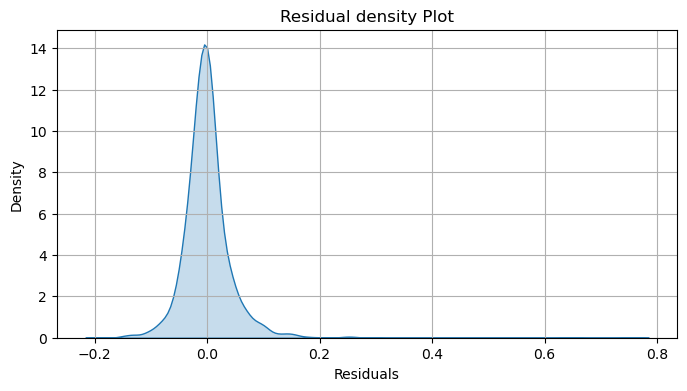

p-value: 0.0


In [178]:
# Specify what RE variables to include
re = ["Time count"]

# Run train-test iterations
(
    df_output_train,
    df_output_test,
    models,
    avg_model,
    df_re_params,
    df_re_x_train,
    df_re_x_test,
) = run_multiple_train_test(X_fe=X_fe, y=y, re=re, num_iter=10)

# Plot how well the model performs
plot_train_test_results(df_output_test)

# Run Shapiro-Wilk normality test on residuals
residuals = df_output_test["Pred"] - df_output_test["Actual"]
res = shapiro(residuals)
print(f"p-value: {round(res[1], 3)}")

**Conclusion:** While it seems that lakes have somewhat different slopes for the Time count variable (i.e. they exhibit different trends), the inclusion of this random effect has a fairly marginal impact on the overall results: from 0.806 to 0.814 in R2 score and 0.824 to 0.837 in accuracy.

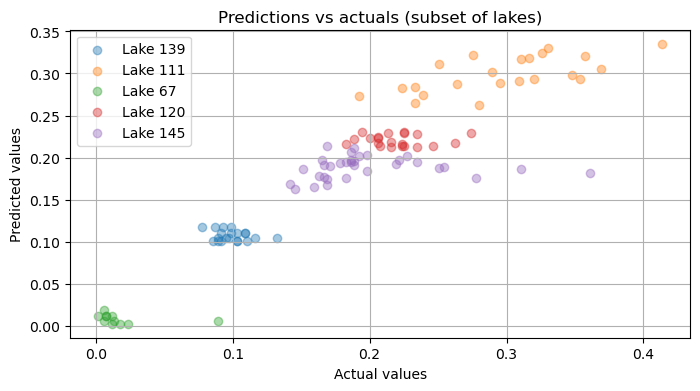

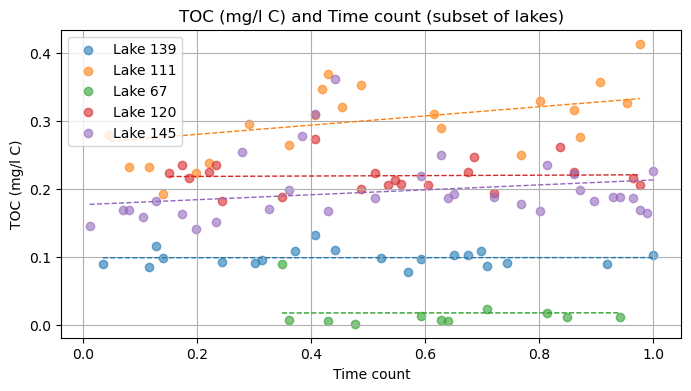

In [179]:
# Visualize random effects for group of lakes
lake_subset = list(np.random.choice(df_output_test["Lake"].unique(), 5))

# Predicted values and actuals for subset of lakes
plot_lake_subset_results(df_output_test, lake_subset)

# Visualize differences in slopes
plot_lake_intercept_slope(
    df_output_test, df_re_params, df_re_x_test, "Time count", avg_model, lake_subset
)